In [4]:
import visa 
import numpy as np
import serial
import time
import os
import math
import h5py
from utils import *
from pathlib import Path
path = os.getcwd()
path = Path(path)
print(Path(str(path.parent) + '\\Classes\\') )

import sys
sys.path.append(str(path.parent) + '\\Classes\\')
from SMA100B import *
from vna import *
from SIM928 import *

%load_ext autoreload
%autoreload 2

C:\Users\oper\Desktop\labparamp\Env\paramp\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


C:\Users\oper\Desktop\labparamp\QTLab2122\TWPA\Classes
C:\Users\oper\Desktop\labparamp\QTLab2122\TWPA\Classes


In [33]:
%matplotlib notebook

In [3]:
field_fox = vna('192.168.3.3')
field_fox.query('*IDN?')

'Keysight Technologies,N9916A,MY53104702,A.08.01\n'

In [4]:
pump = SMA100B('192.168.3.2')
pump.query('*IDN?')

'Rohde&Schwarz,SMA100B,1419.8888K02/105168,4.70.205.75  \n'

In [5]:
bias = SIM928('COM28', '4')
bias.query('*IDN?')

'Stanford_Research_Systems,SIM928,s/n030465,ver2.2\r\n'

In [7]:
#pump power
p0 = -18.5 #-45
p1 = -17.5 #-15 #best: 19
dp = 0.10 #2
P = np.arange(p0, p1, dp)
N_p = P.size
print(N_p)

#pump frequency
f0 = 17.75 #16.5
f1 = 18.25 #17.5
df = 50e-5
F = np.arange(f0, f1, df)
N_f = F.size
print(N_f)

#bias voltageat SIM
v0 = 0.300
v1 = 0.340
dv = 0.002
V = np.arange(v0, v1, dv)
N_v = V.size
print(N_v)

f, d = field_fox.print_data()
n_points = f.size

filename = 'scan_banda_completaz.hdf5'
storage_hdf5(filename, F, 'pump_freq')
storage_hdf5(filename, P, 'pump_pow')
storage_hdf5(filename, V, 'bias_voltage')
#print(n_points)

spectra = np.empty((N_f, N_v, N_p, n_points*4))

10
2500
21


In [8]:
start_time = time.time()
for i in range(0, N_v):
    bias.set_voltage(V[i])
    for j in range(0, N_p):
        pump.set_ampl(P[j])
        for k in range(0, N_f):
            pump.set_freq(F[k]*1e9)
            d = np.empty()
            for l in range(0,4):
                field_fox.set_range(2e9+l*2e9, 4e9+l*2e9)
                f, d_partial = field_fox.print_data()
                d = np.hstack(d, d_partial)
            spectra[k,i,j,:] = d[1:]
final_time = time.time() - start_time
storage_hdf5(filename, spectra, 'spectra')


In [19]:
final_time/3600

101.19699313693576

In [9]:
M = np.amax(maxima)
print(M)

-22.6554298


In [12]:
A, B, C = indexes_of_max(maxima)
print(A)
print(B)
print(C)

C:\Users\oper\Desktop\labparamp\QTLab2122\TWPA\Classes
[839 840 841 842]
[19 19 19 19]
[1 1 1 1]


In [13]:
print(F[A[0]])
print(V[B[0]])
print(P[C[0]])

17.91779999999961
0.338
-18.4


<IPython.core.display.Javascript object>


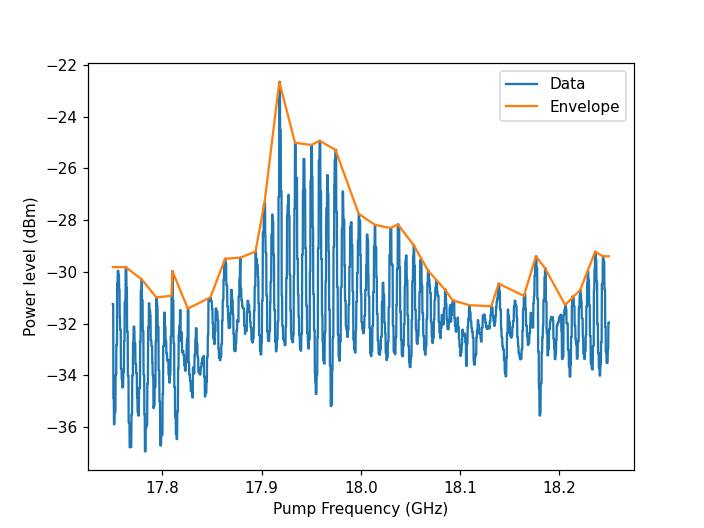

In [38]:
along_fr = maxima[:,19,1]
plt.plot(F, along_fr)
l, h = envelopes(along_fr, dmin = 20, dmax = 20)
plt.plot(F, h)
plt.xlabel('Pump Frequency (GHz)')
plt.ylabel('Power level (dBm)')
plt.legend(['Data', 'Envelope'], loc='best')
plt.savefig('pow_vs_fr_at_TRUE_maximum.png')

<IPython.core.display.Javascript object>


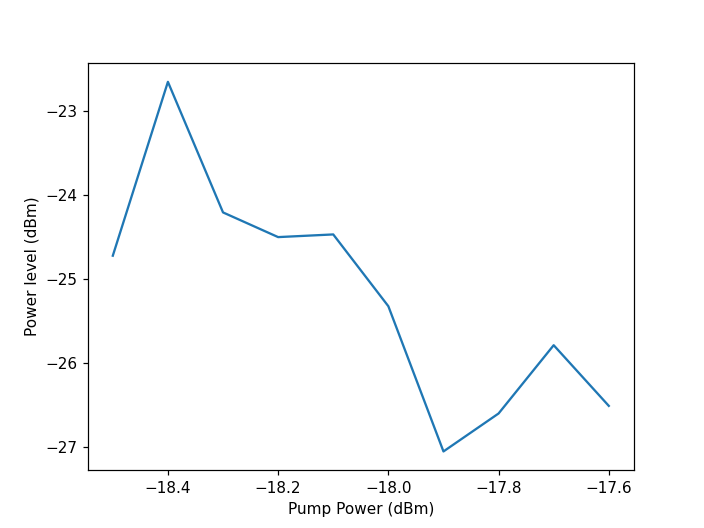

In [39]:
along_pow = maxima[839,19,:]
plt.plot(P, along_pow)
plt.xlabel('Pump Power (dBm)')
plt.ylabel('Power level (dBm)')
plt.savefig('pow_vs_pump_pow_at_TRUE_maximum.png')

<IPython.core.display.Javascript object>


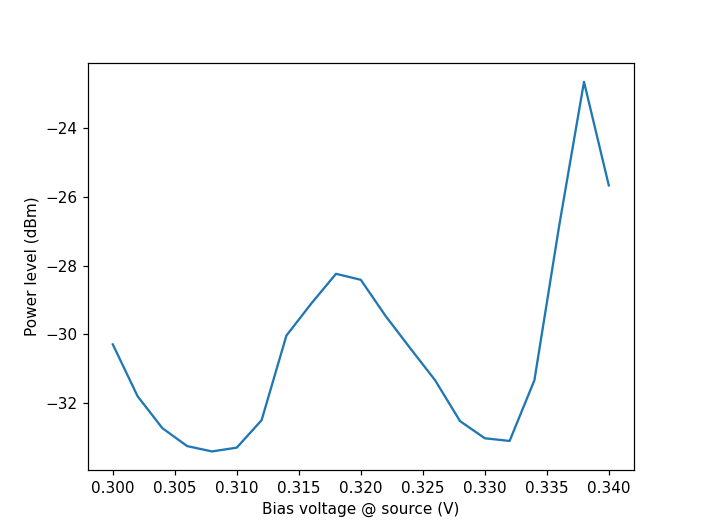

In [40]:
along_volt = maxima[839,:,1]
plt.plot(V, along_volt)
plt.xlabel('Bias voltage @ source (V)')
plt.ylabel('Power level (dBm)')
plt.savefig('pow_vs_volt_at_TRUE_maximum.png')

In [27]:
inviluppi = np.empty((N_f, N_v, N_p))
for j in range(0, N_v):
    #print(V[j], ' V')
    for k in range(0, N_p):
        #print('\t', P[k], ' dBm')
        low, inviluppi[:,j,k] = envelopes(maxima[:,j,k], dmin=20,dmax=20)

print('inviluppi finiti')

inviluppi finiti


<IPython.core.display.Javascript object>


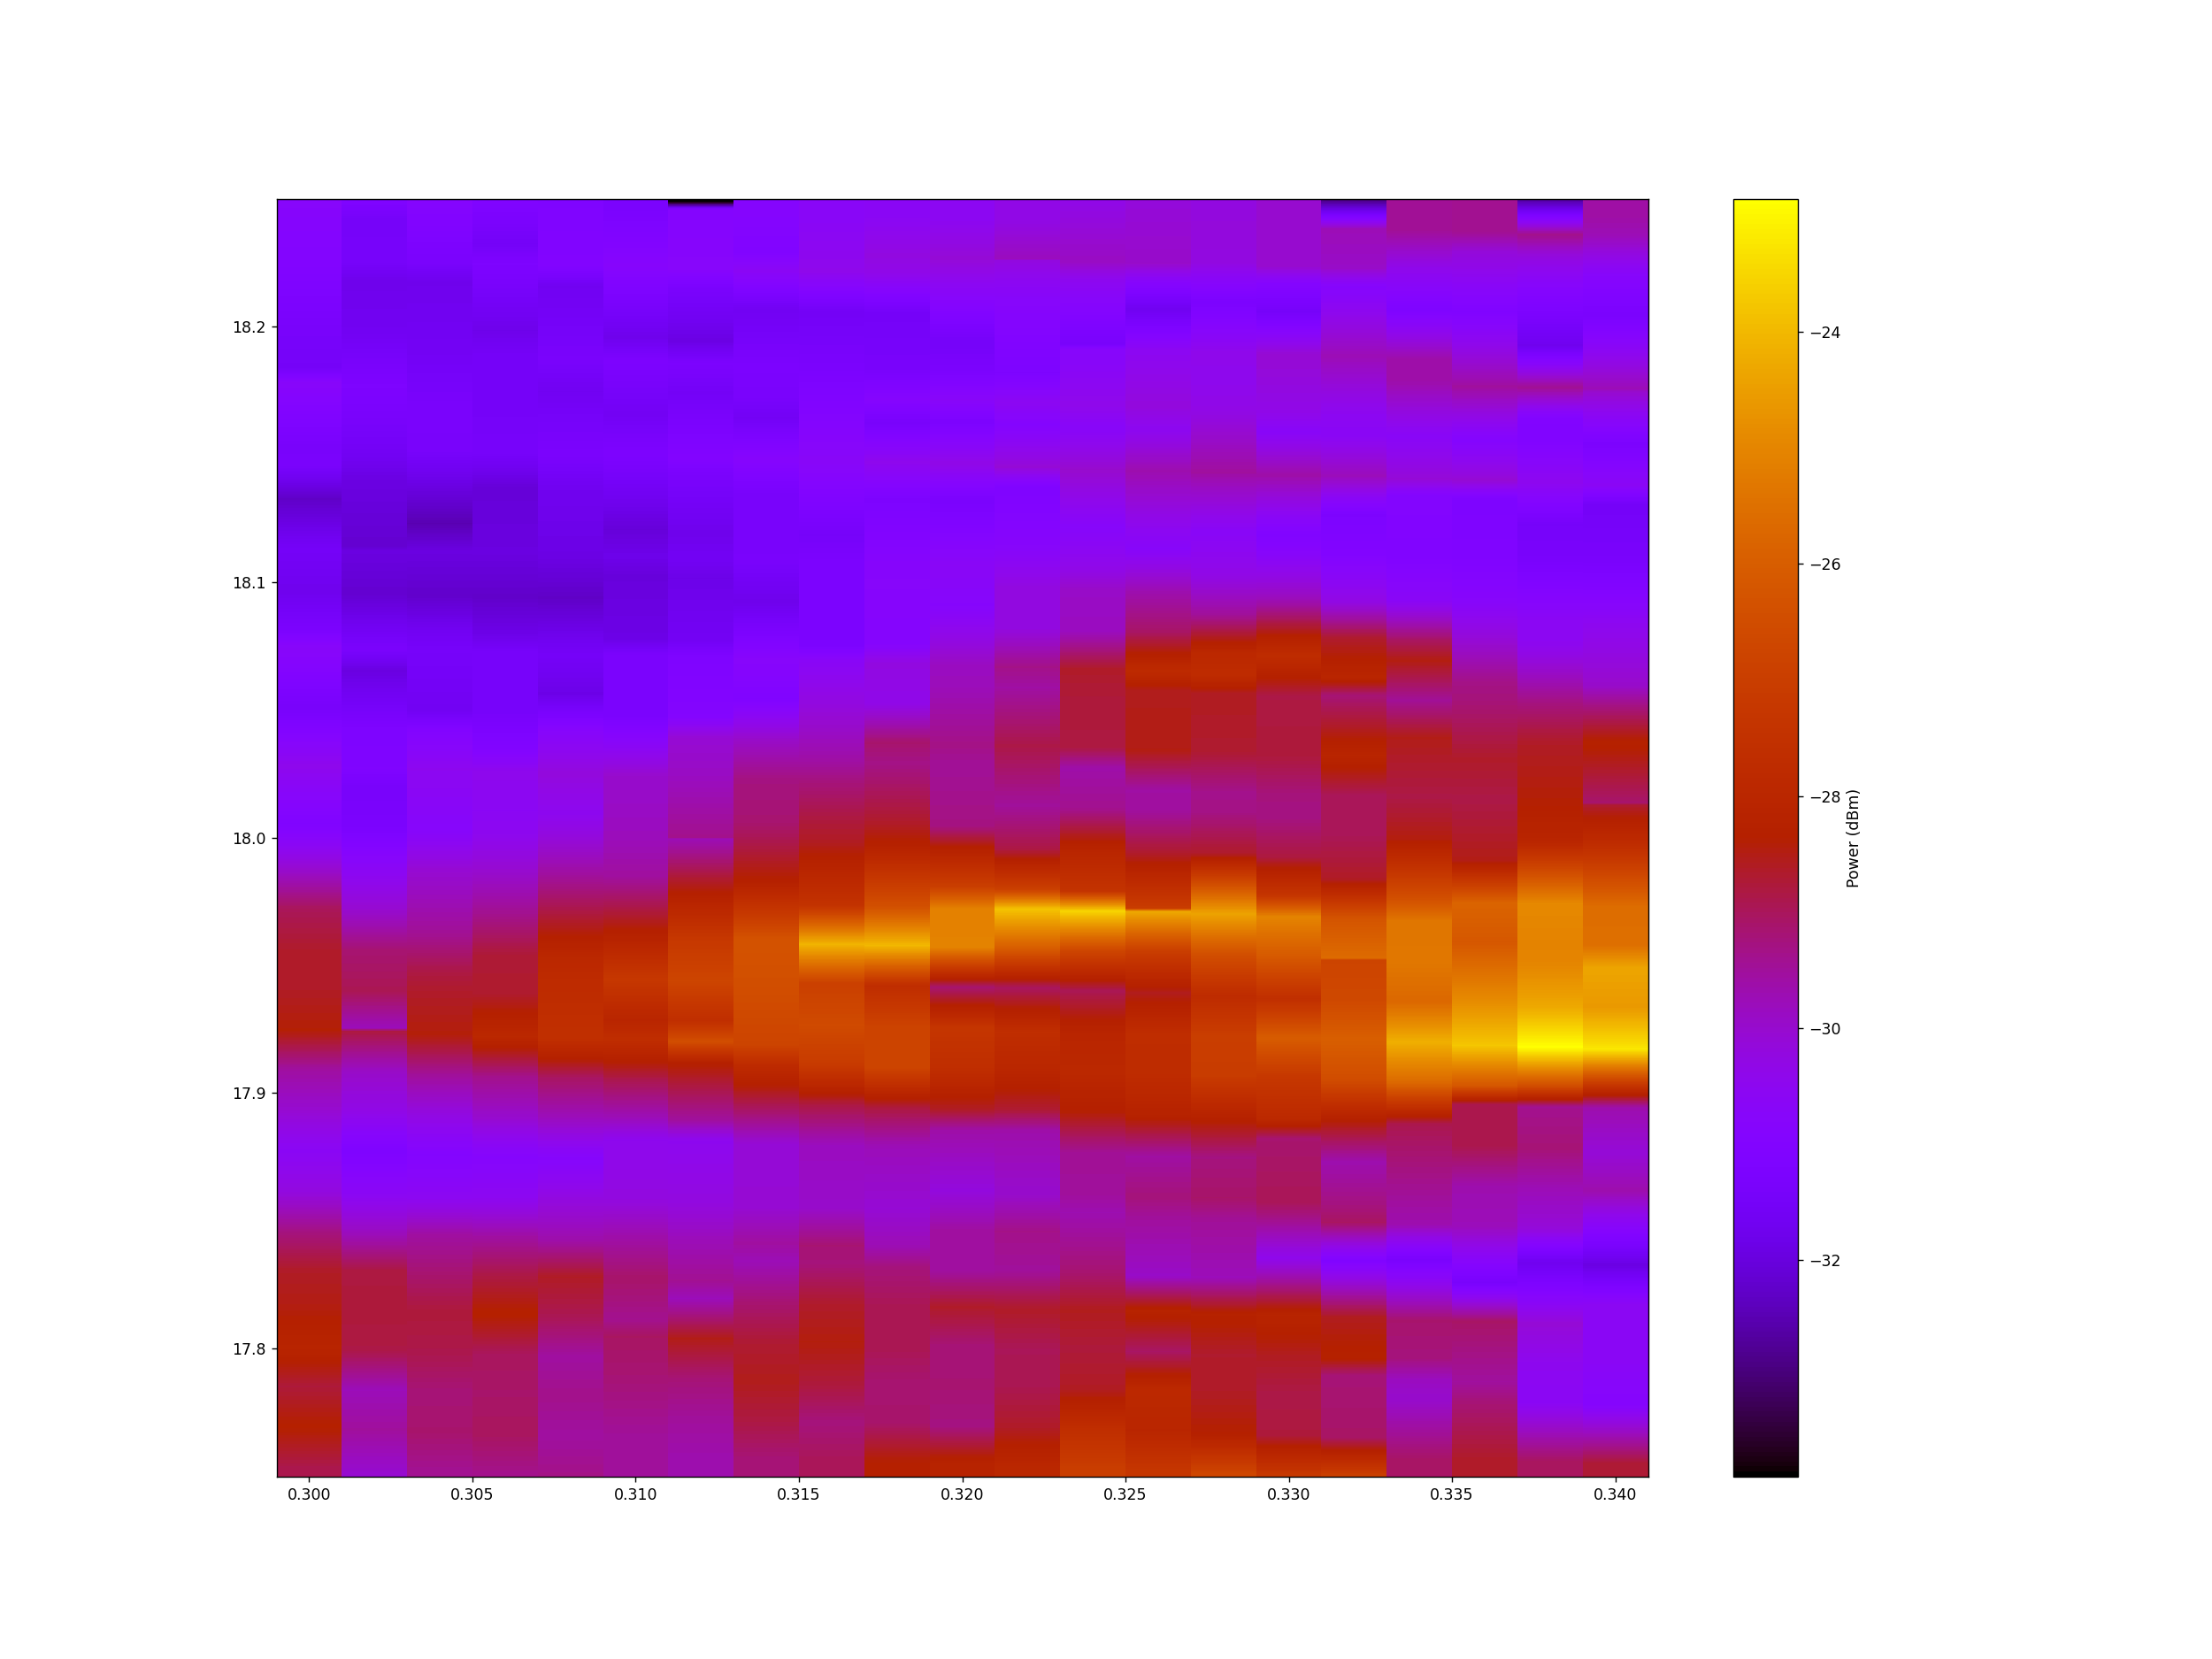

<IPython.core.display.Javascript object>


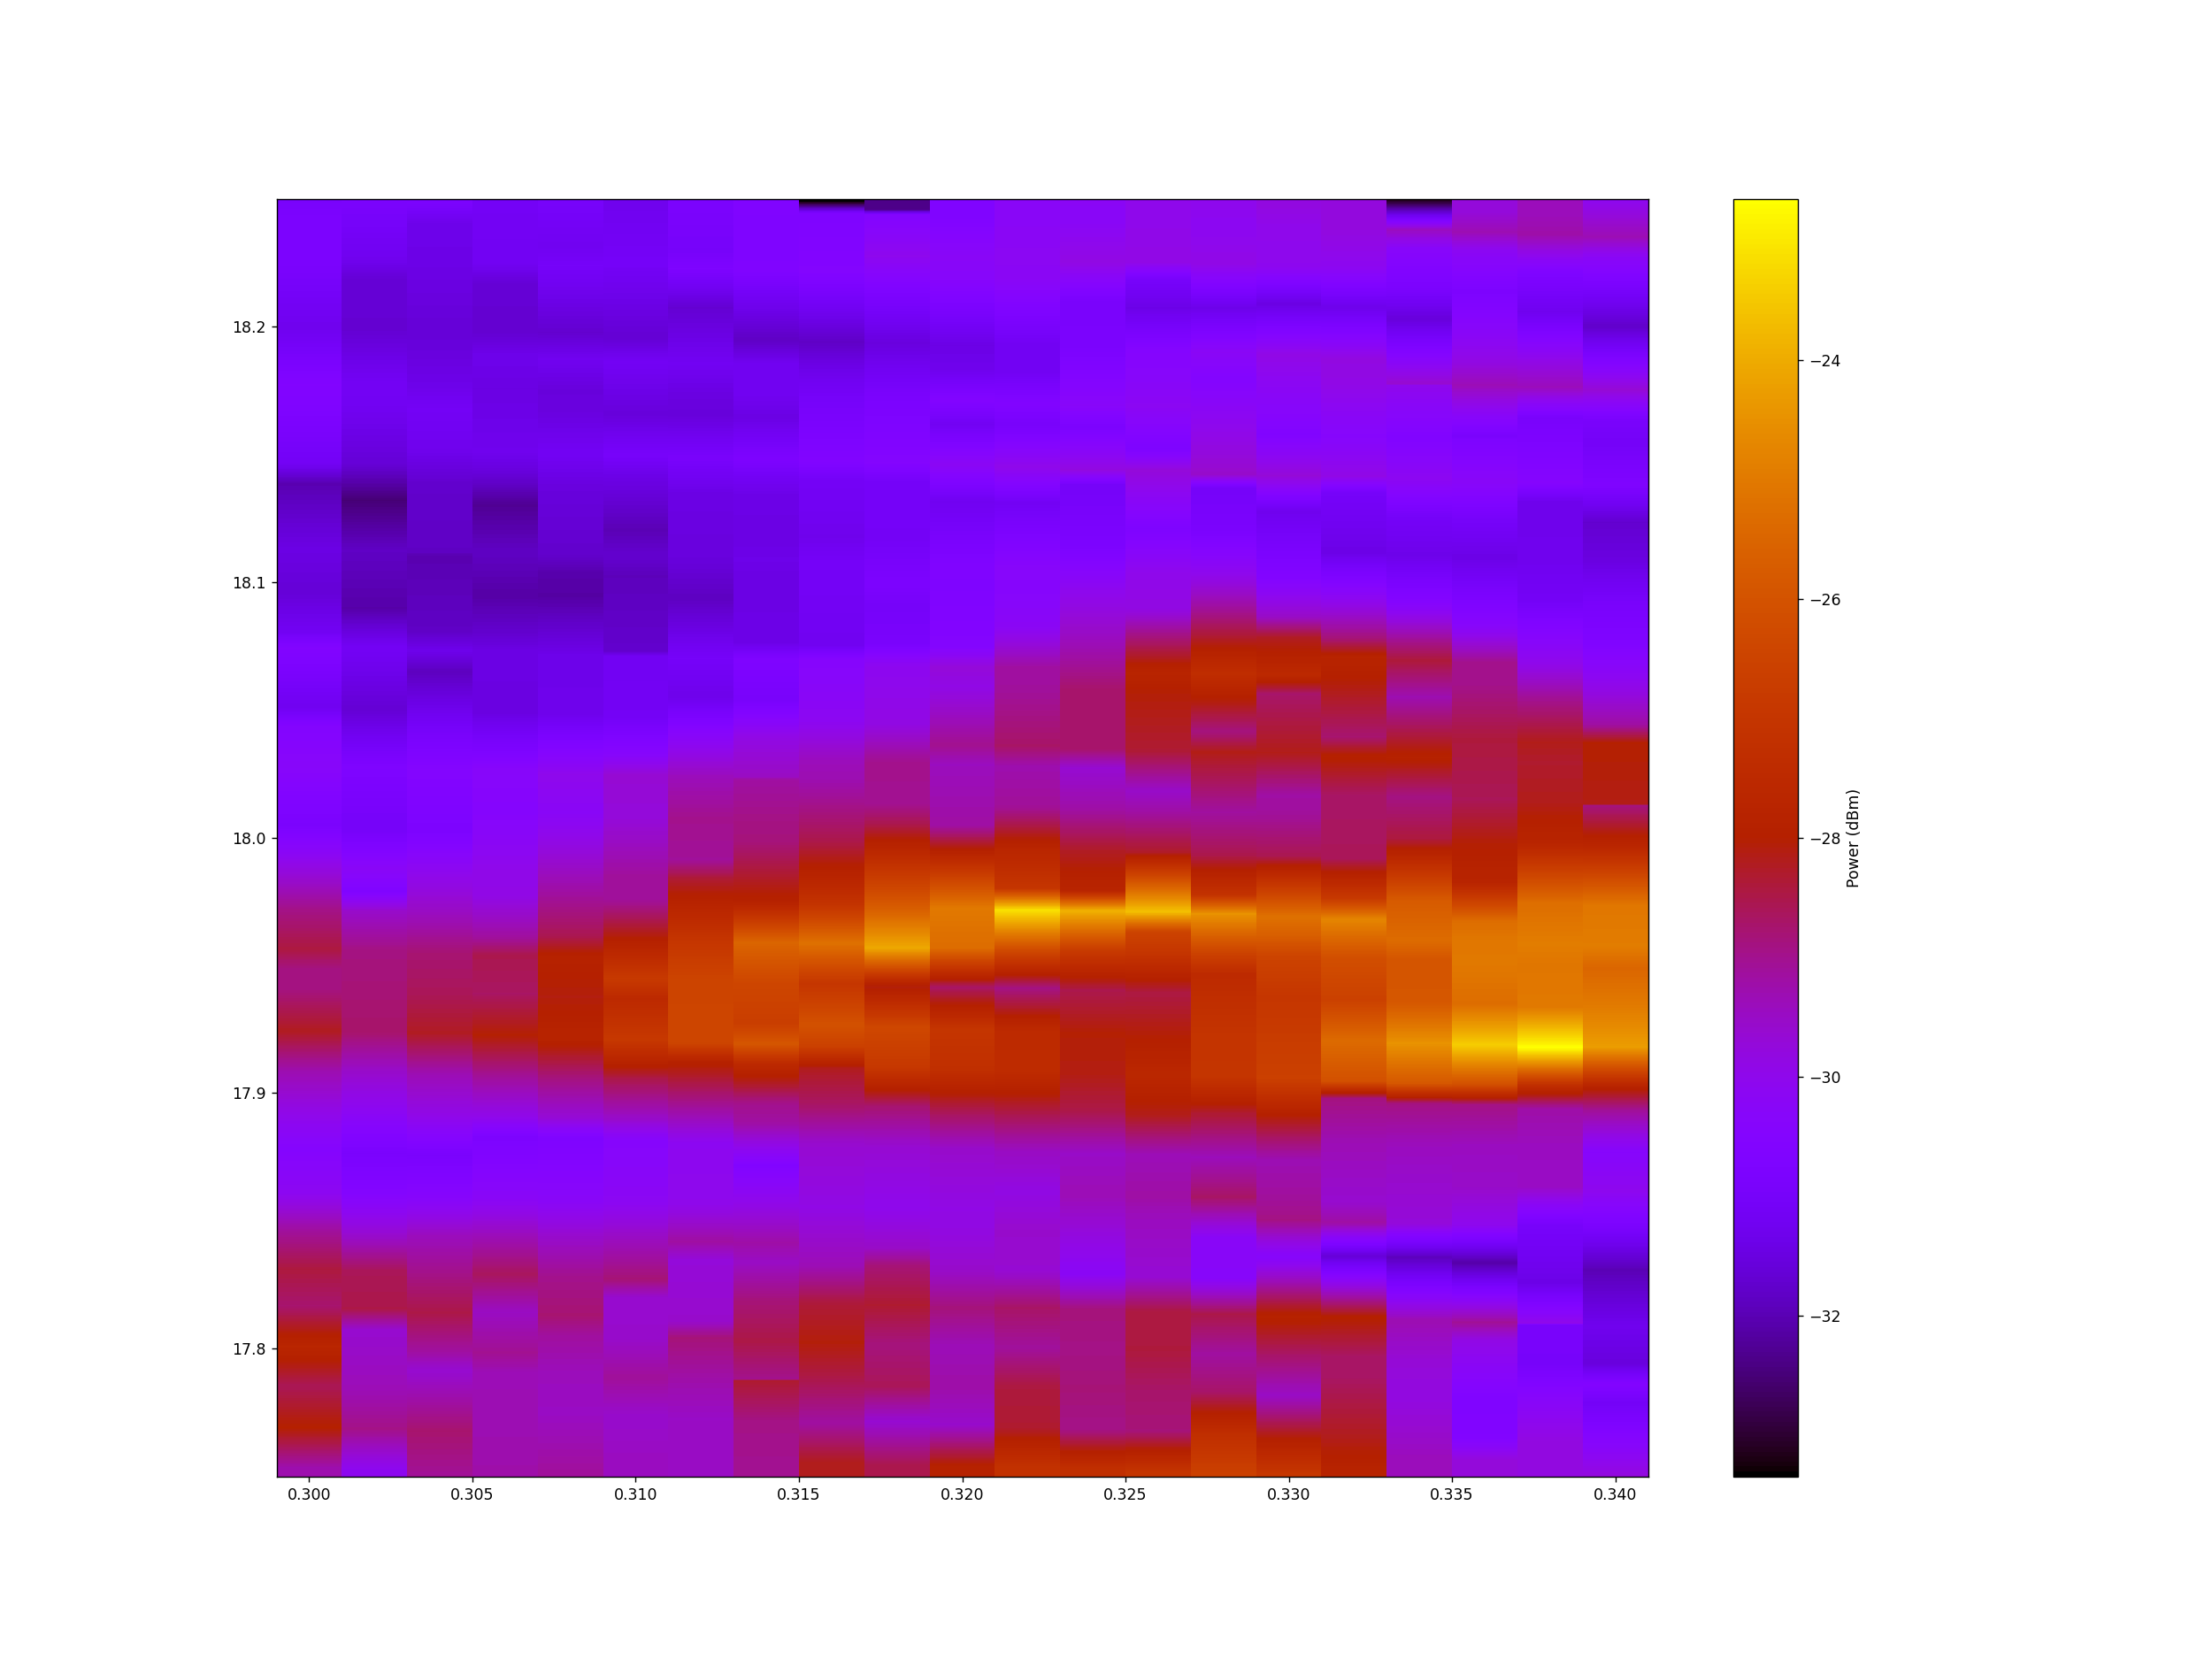

<IPython.core.display.Javascript object>


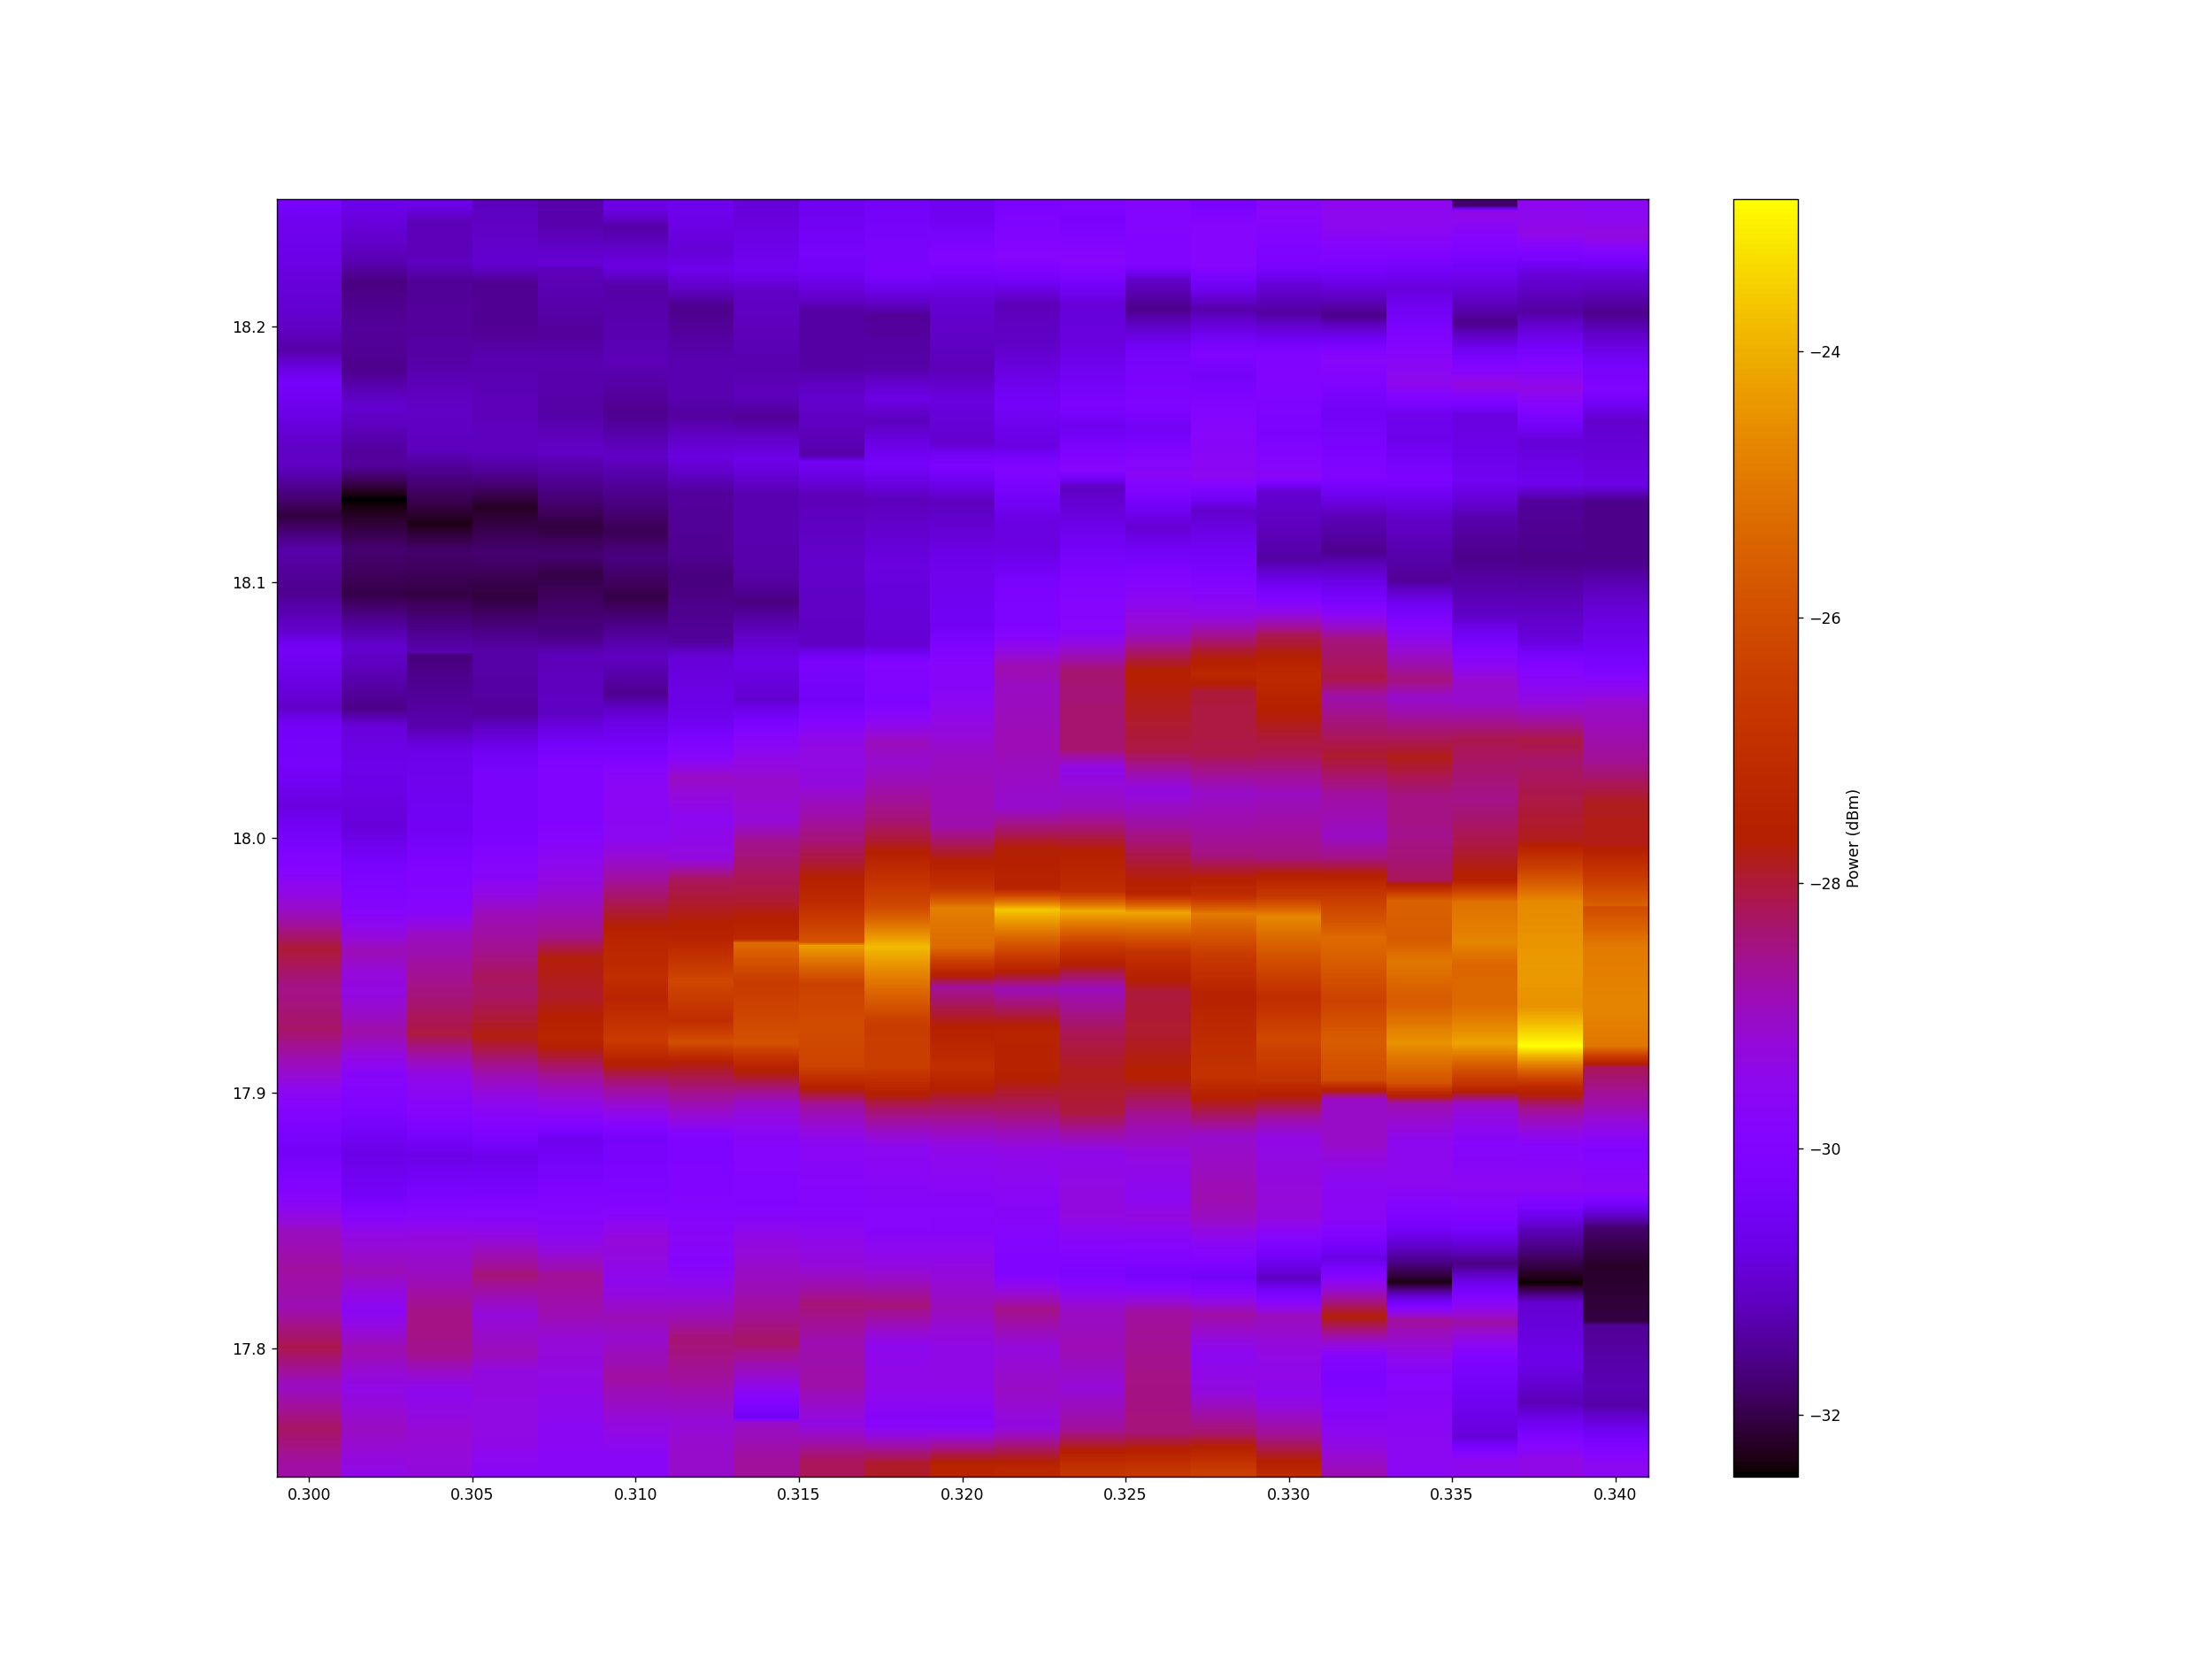

<IPython.core.display.Javascript object>


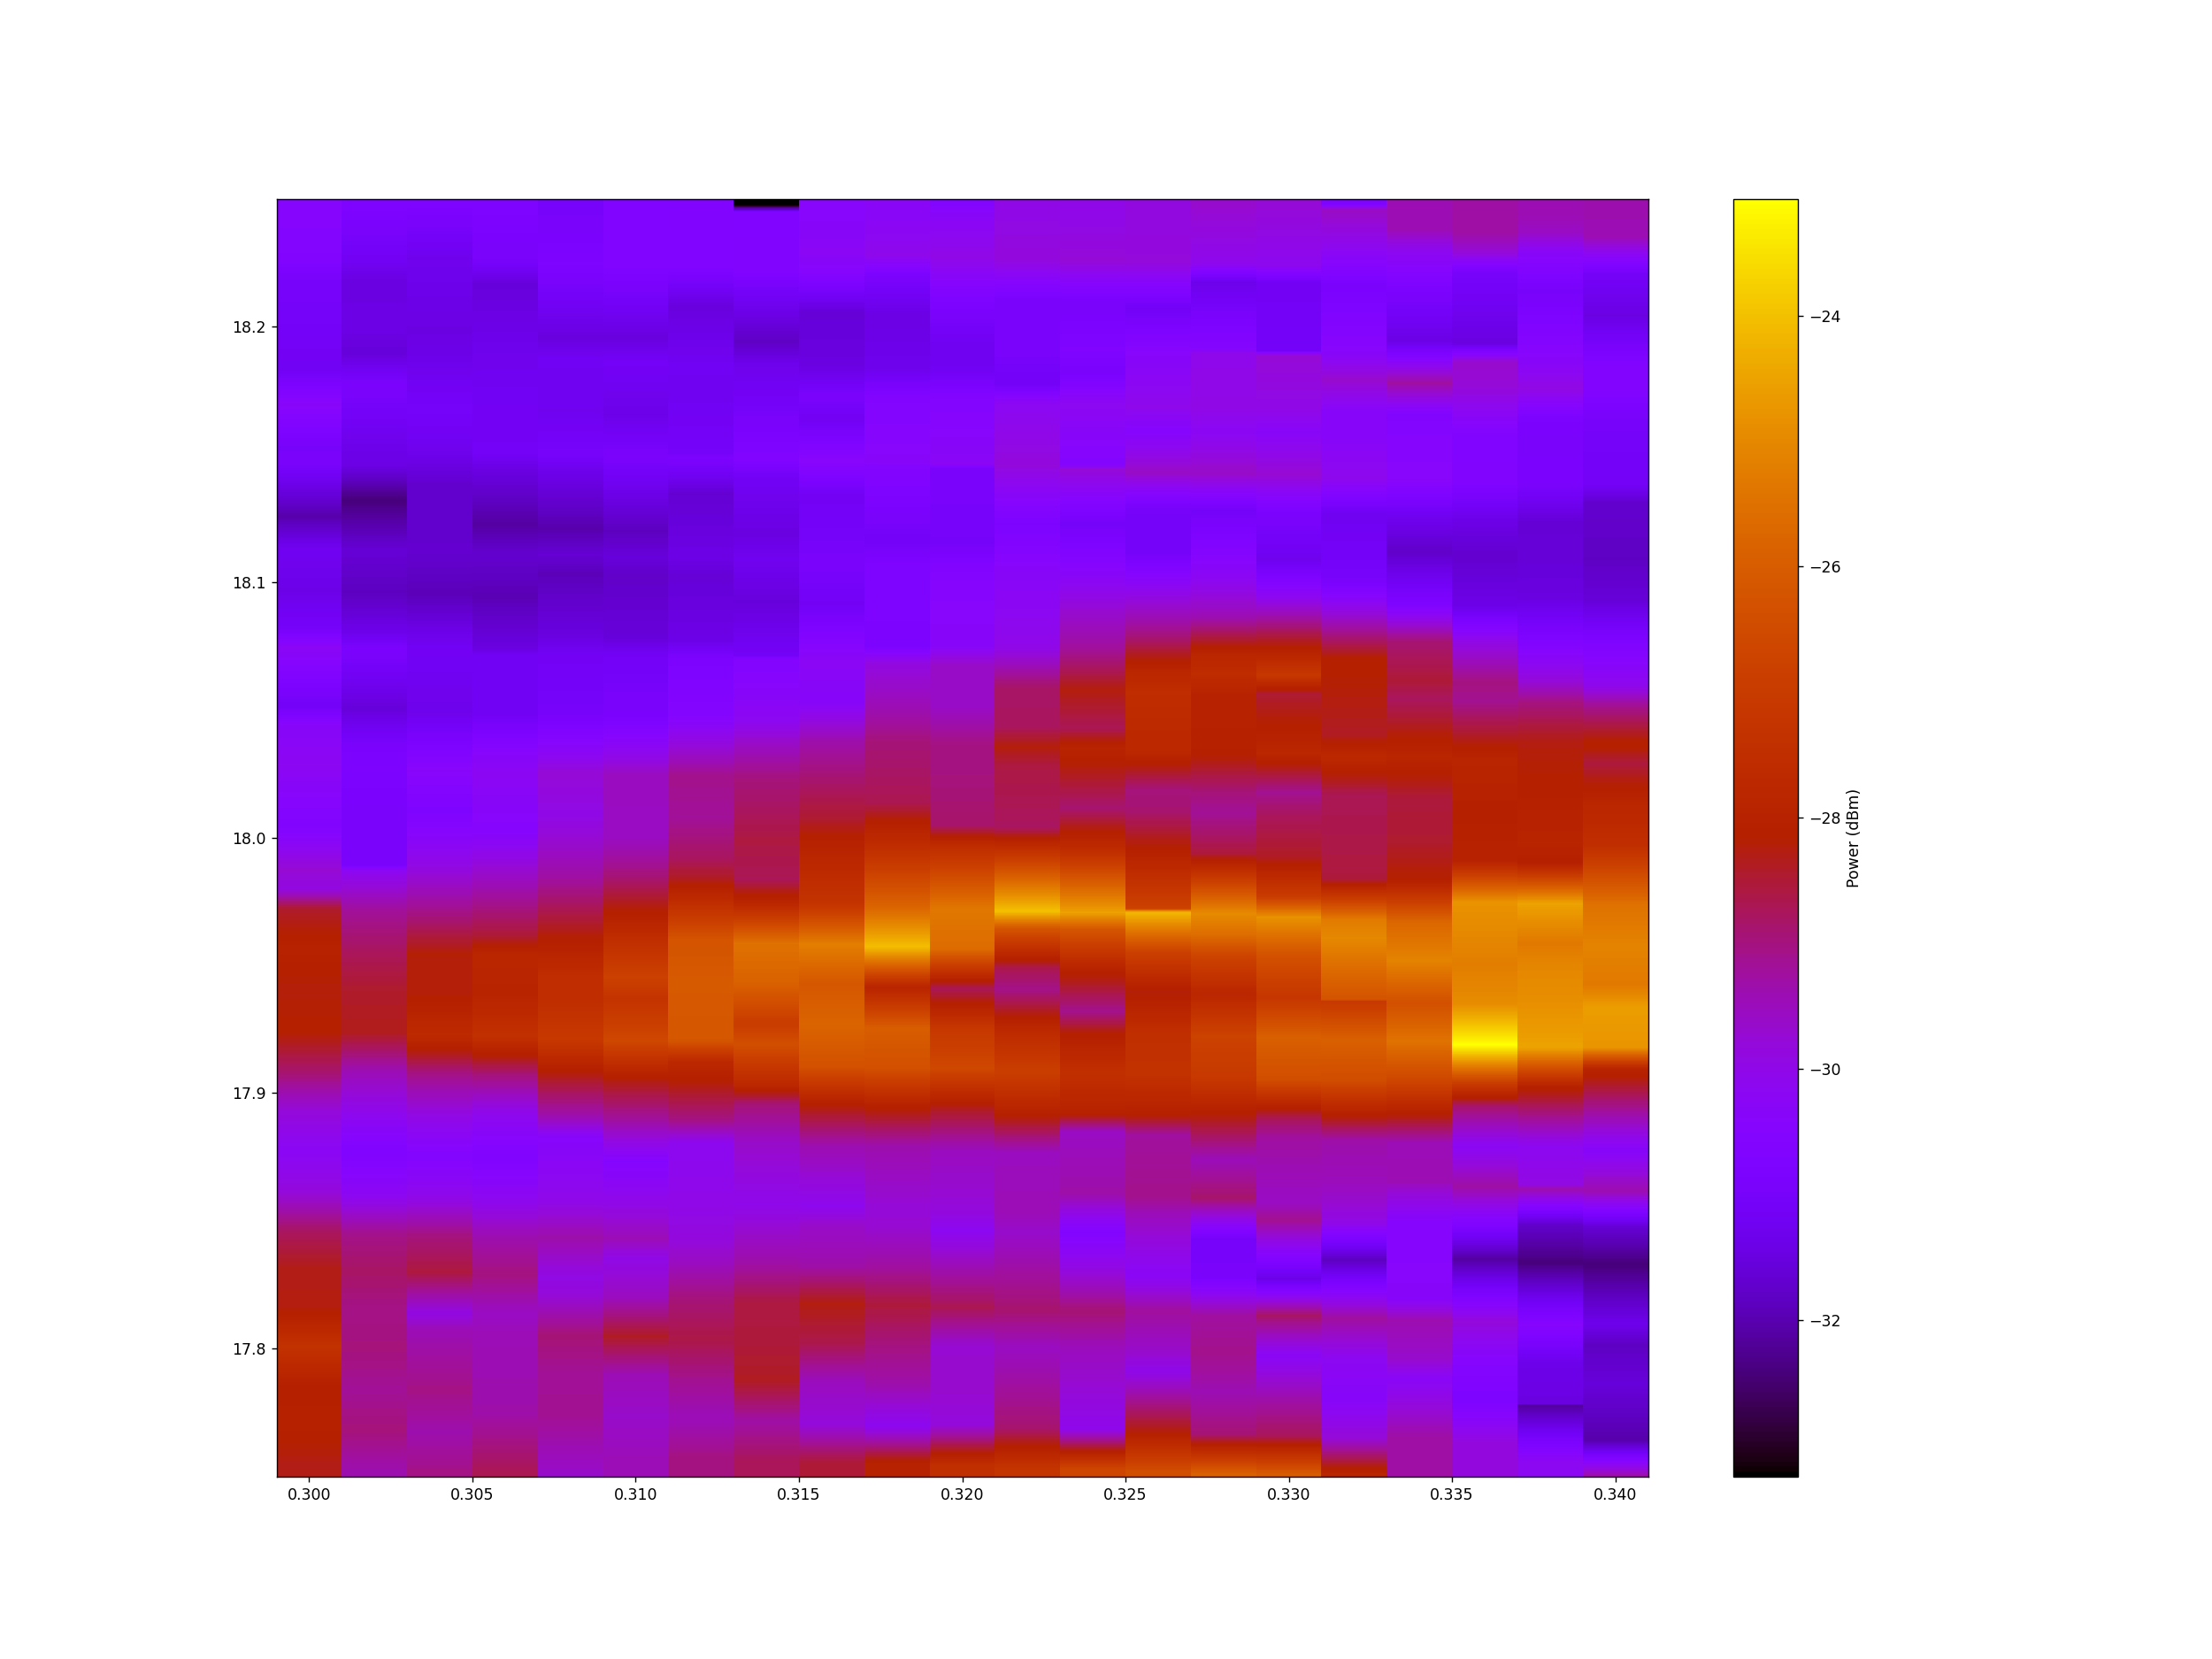

<IPython.core.display.Javascript object>


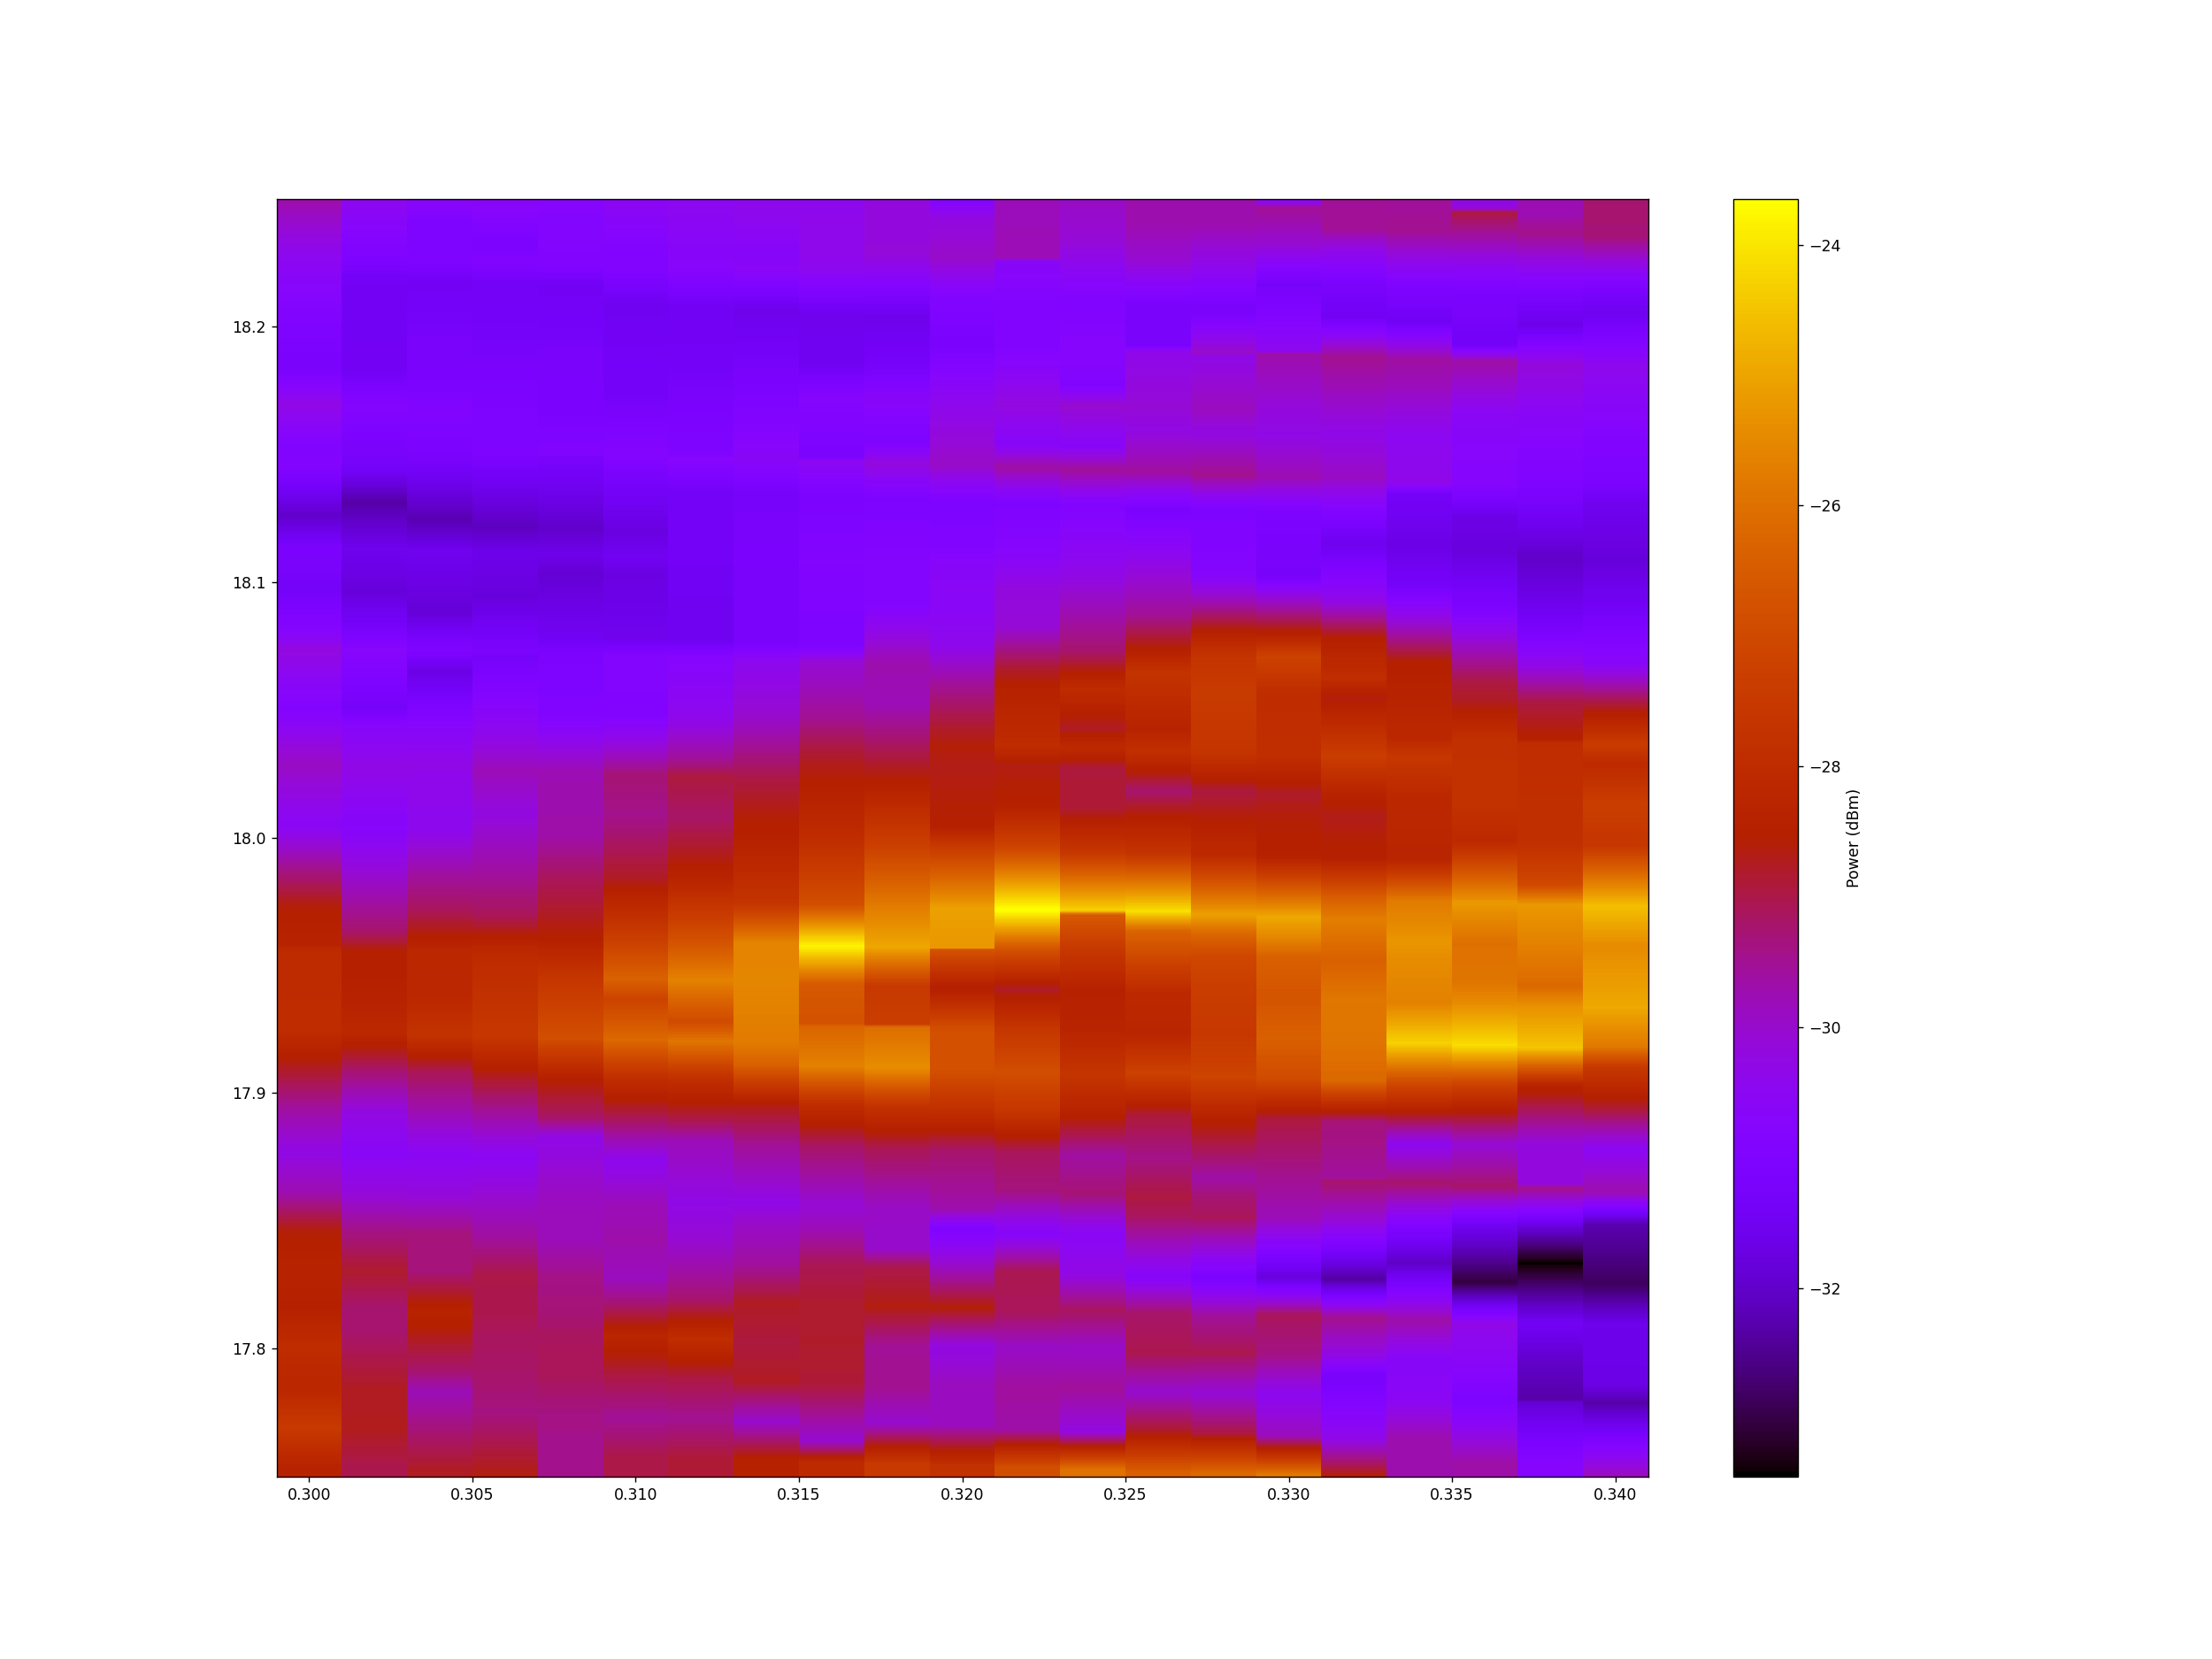

<IPython.core.display.Javascript object>


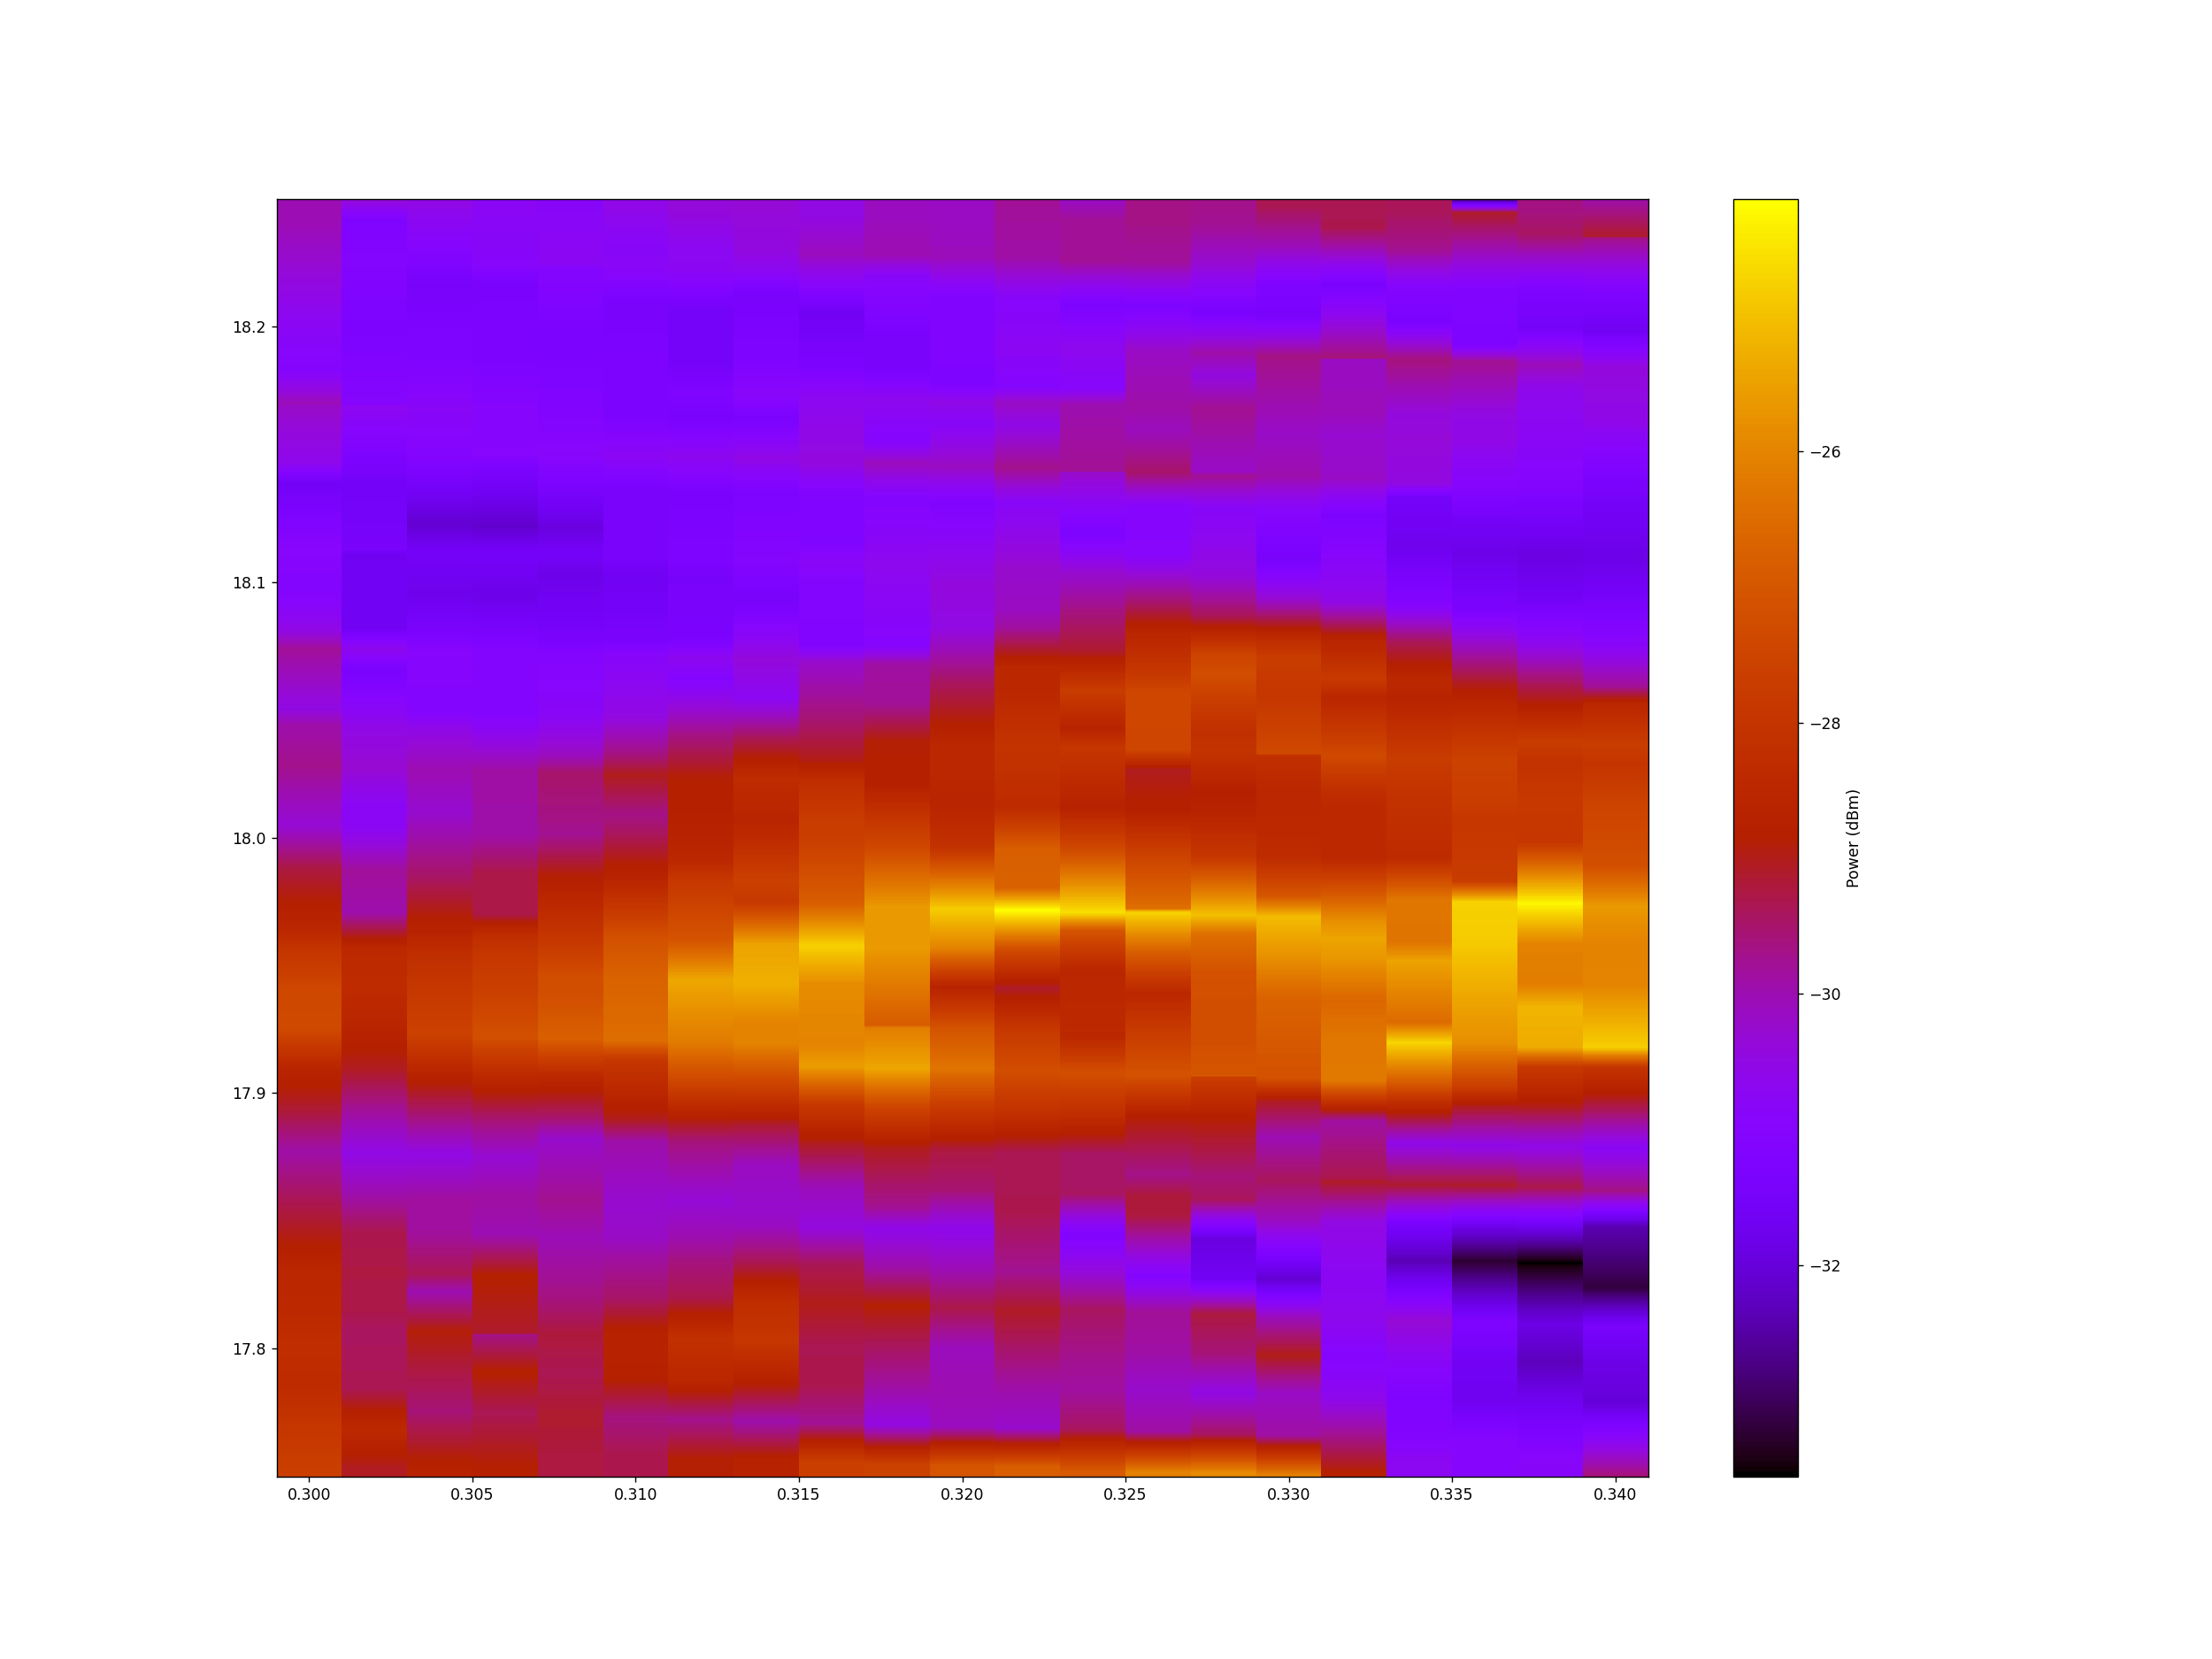

<IPython.core.display.Javascript object>


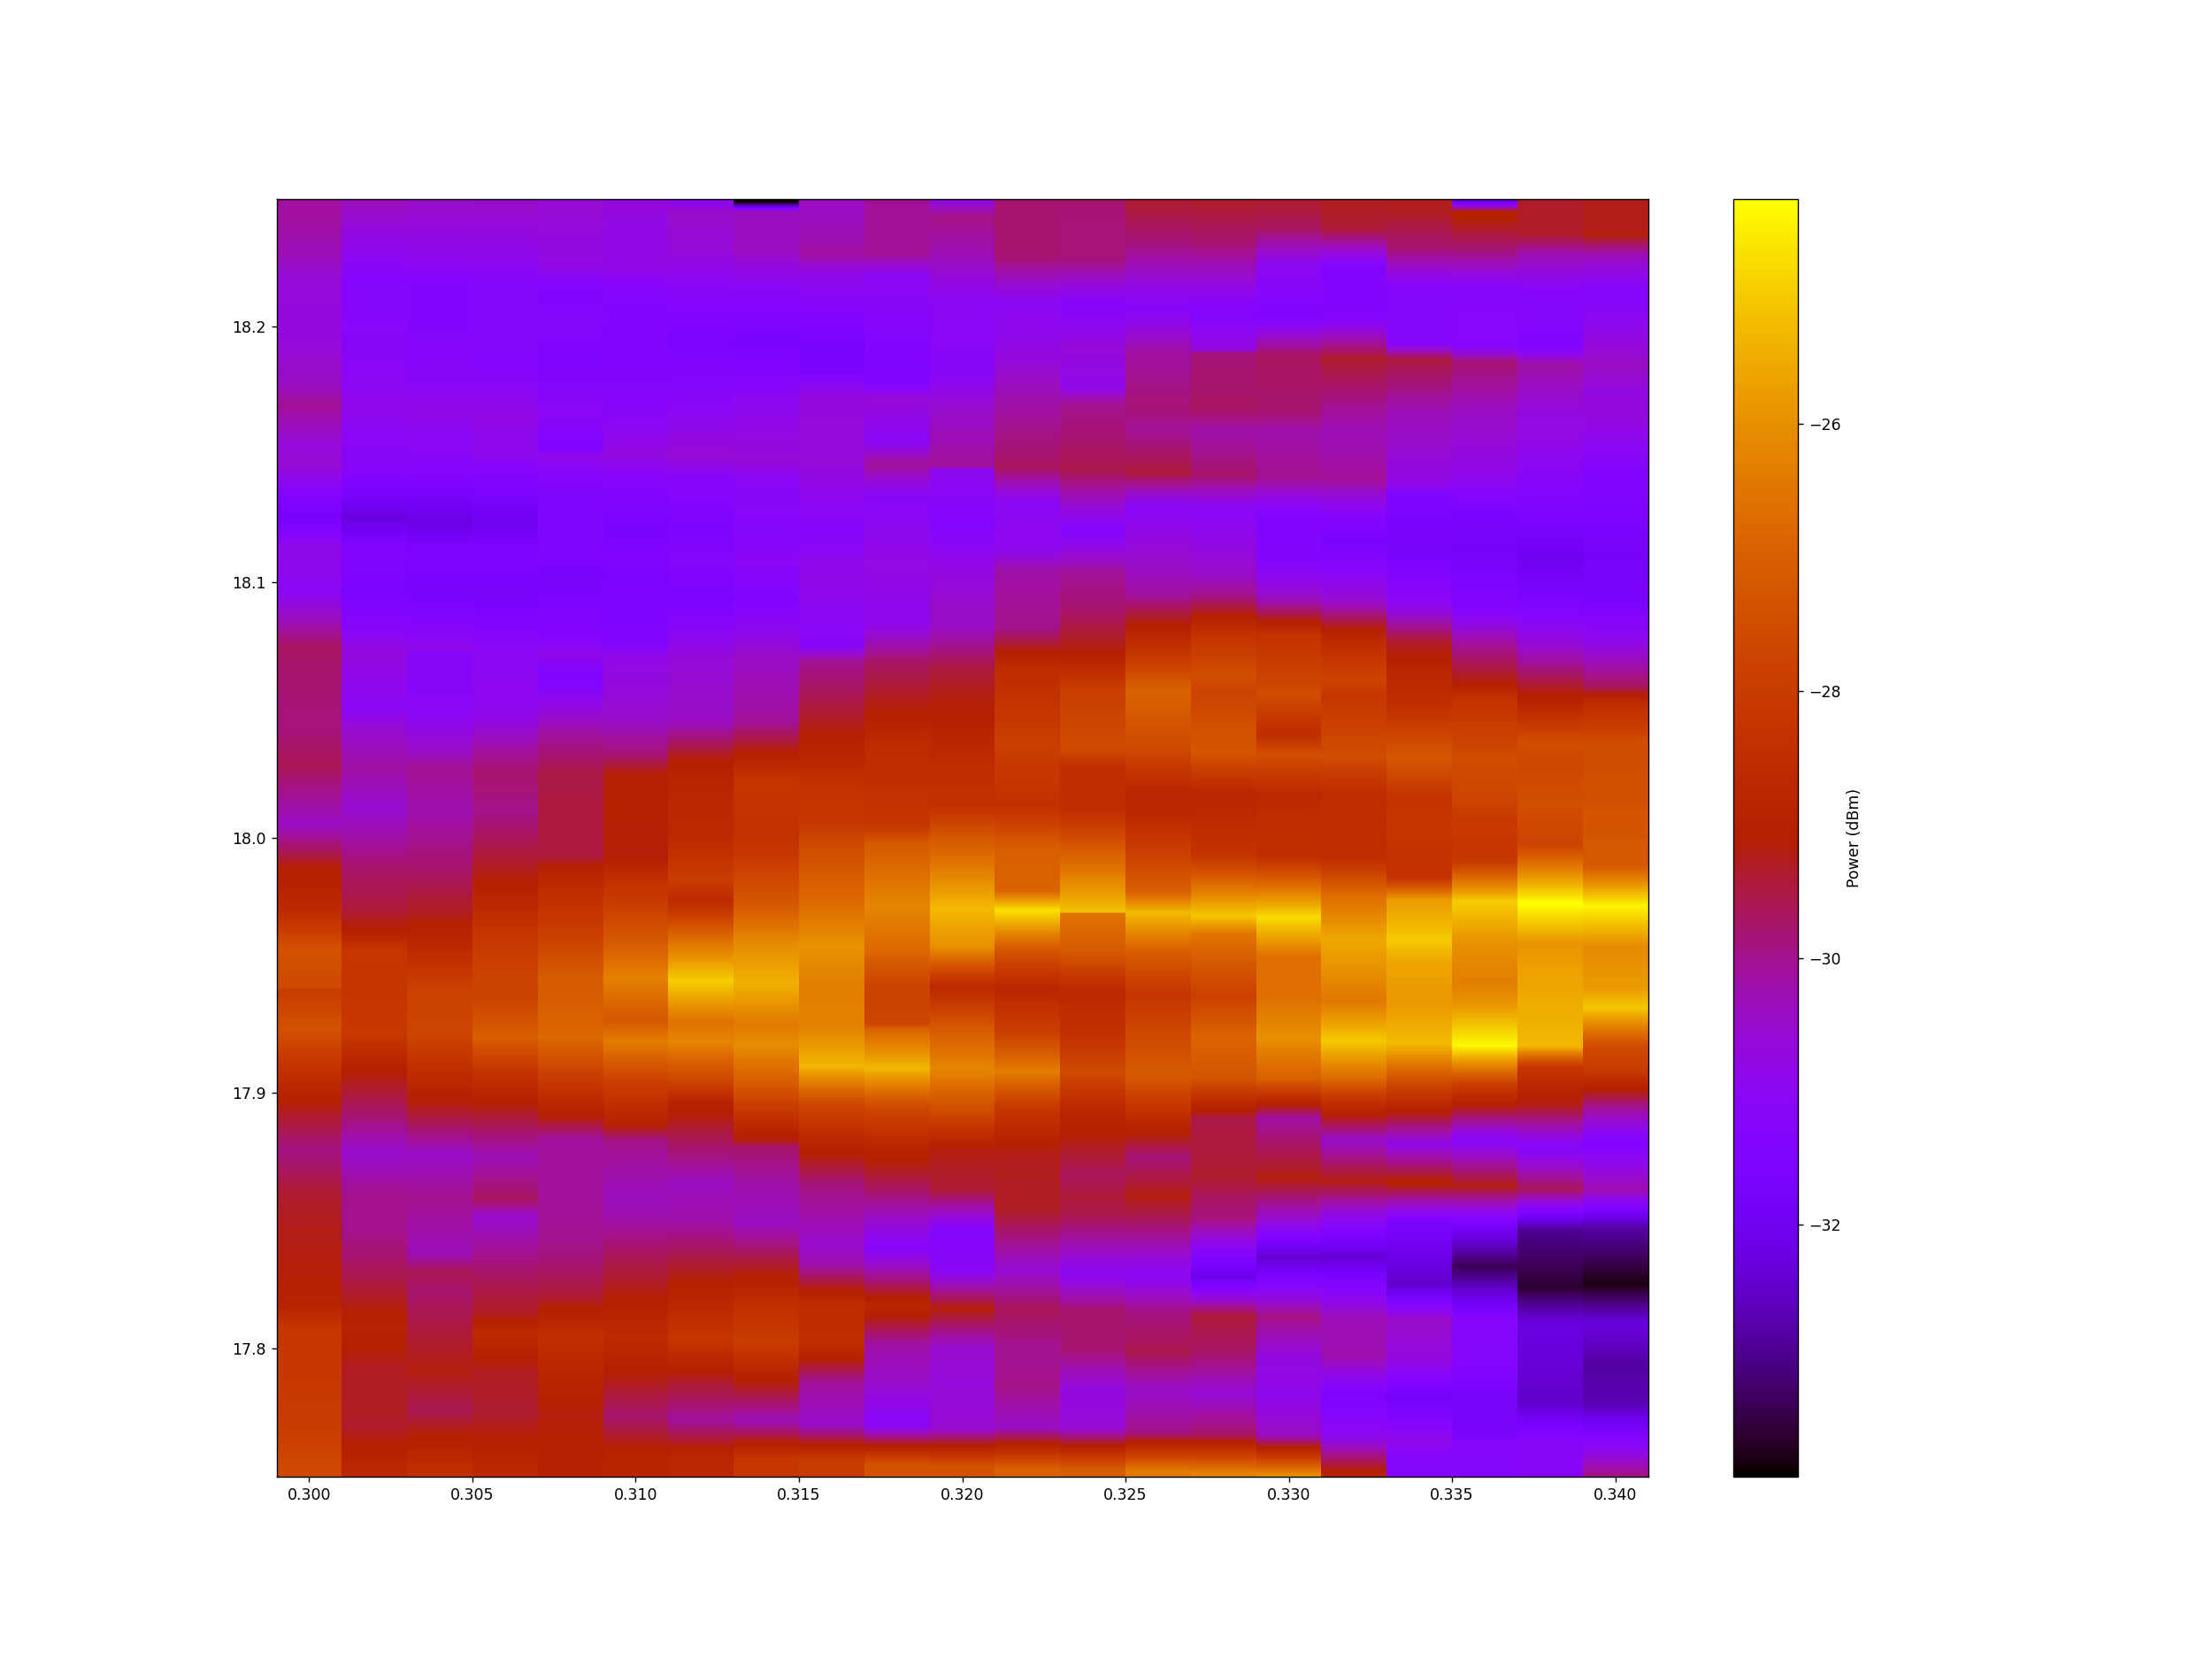

<IPython.core.display.Javascript object>


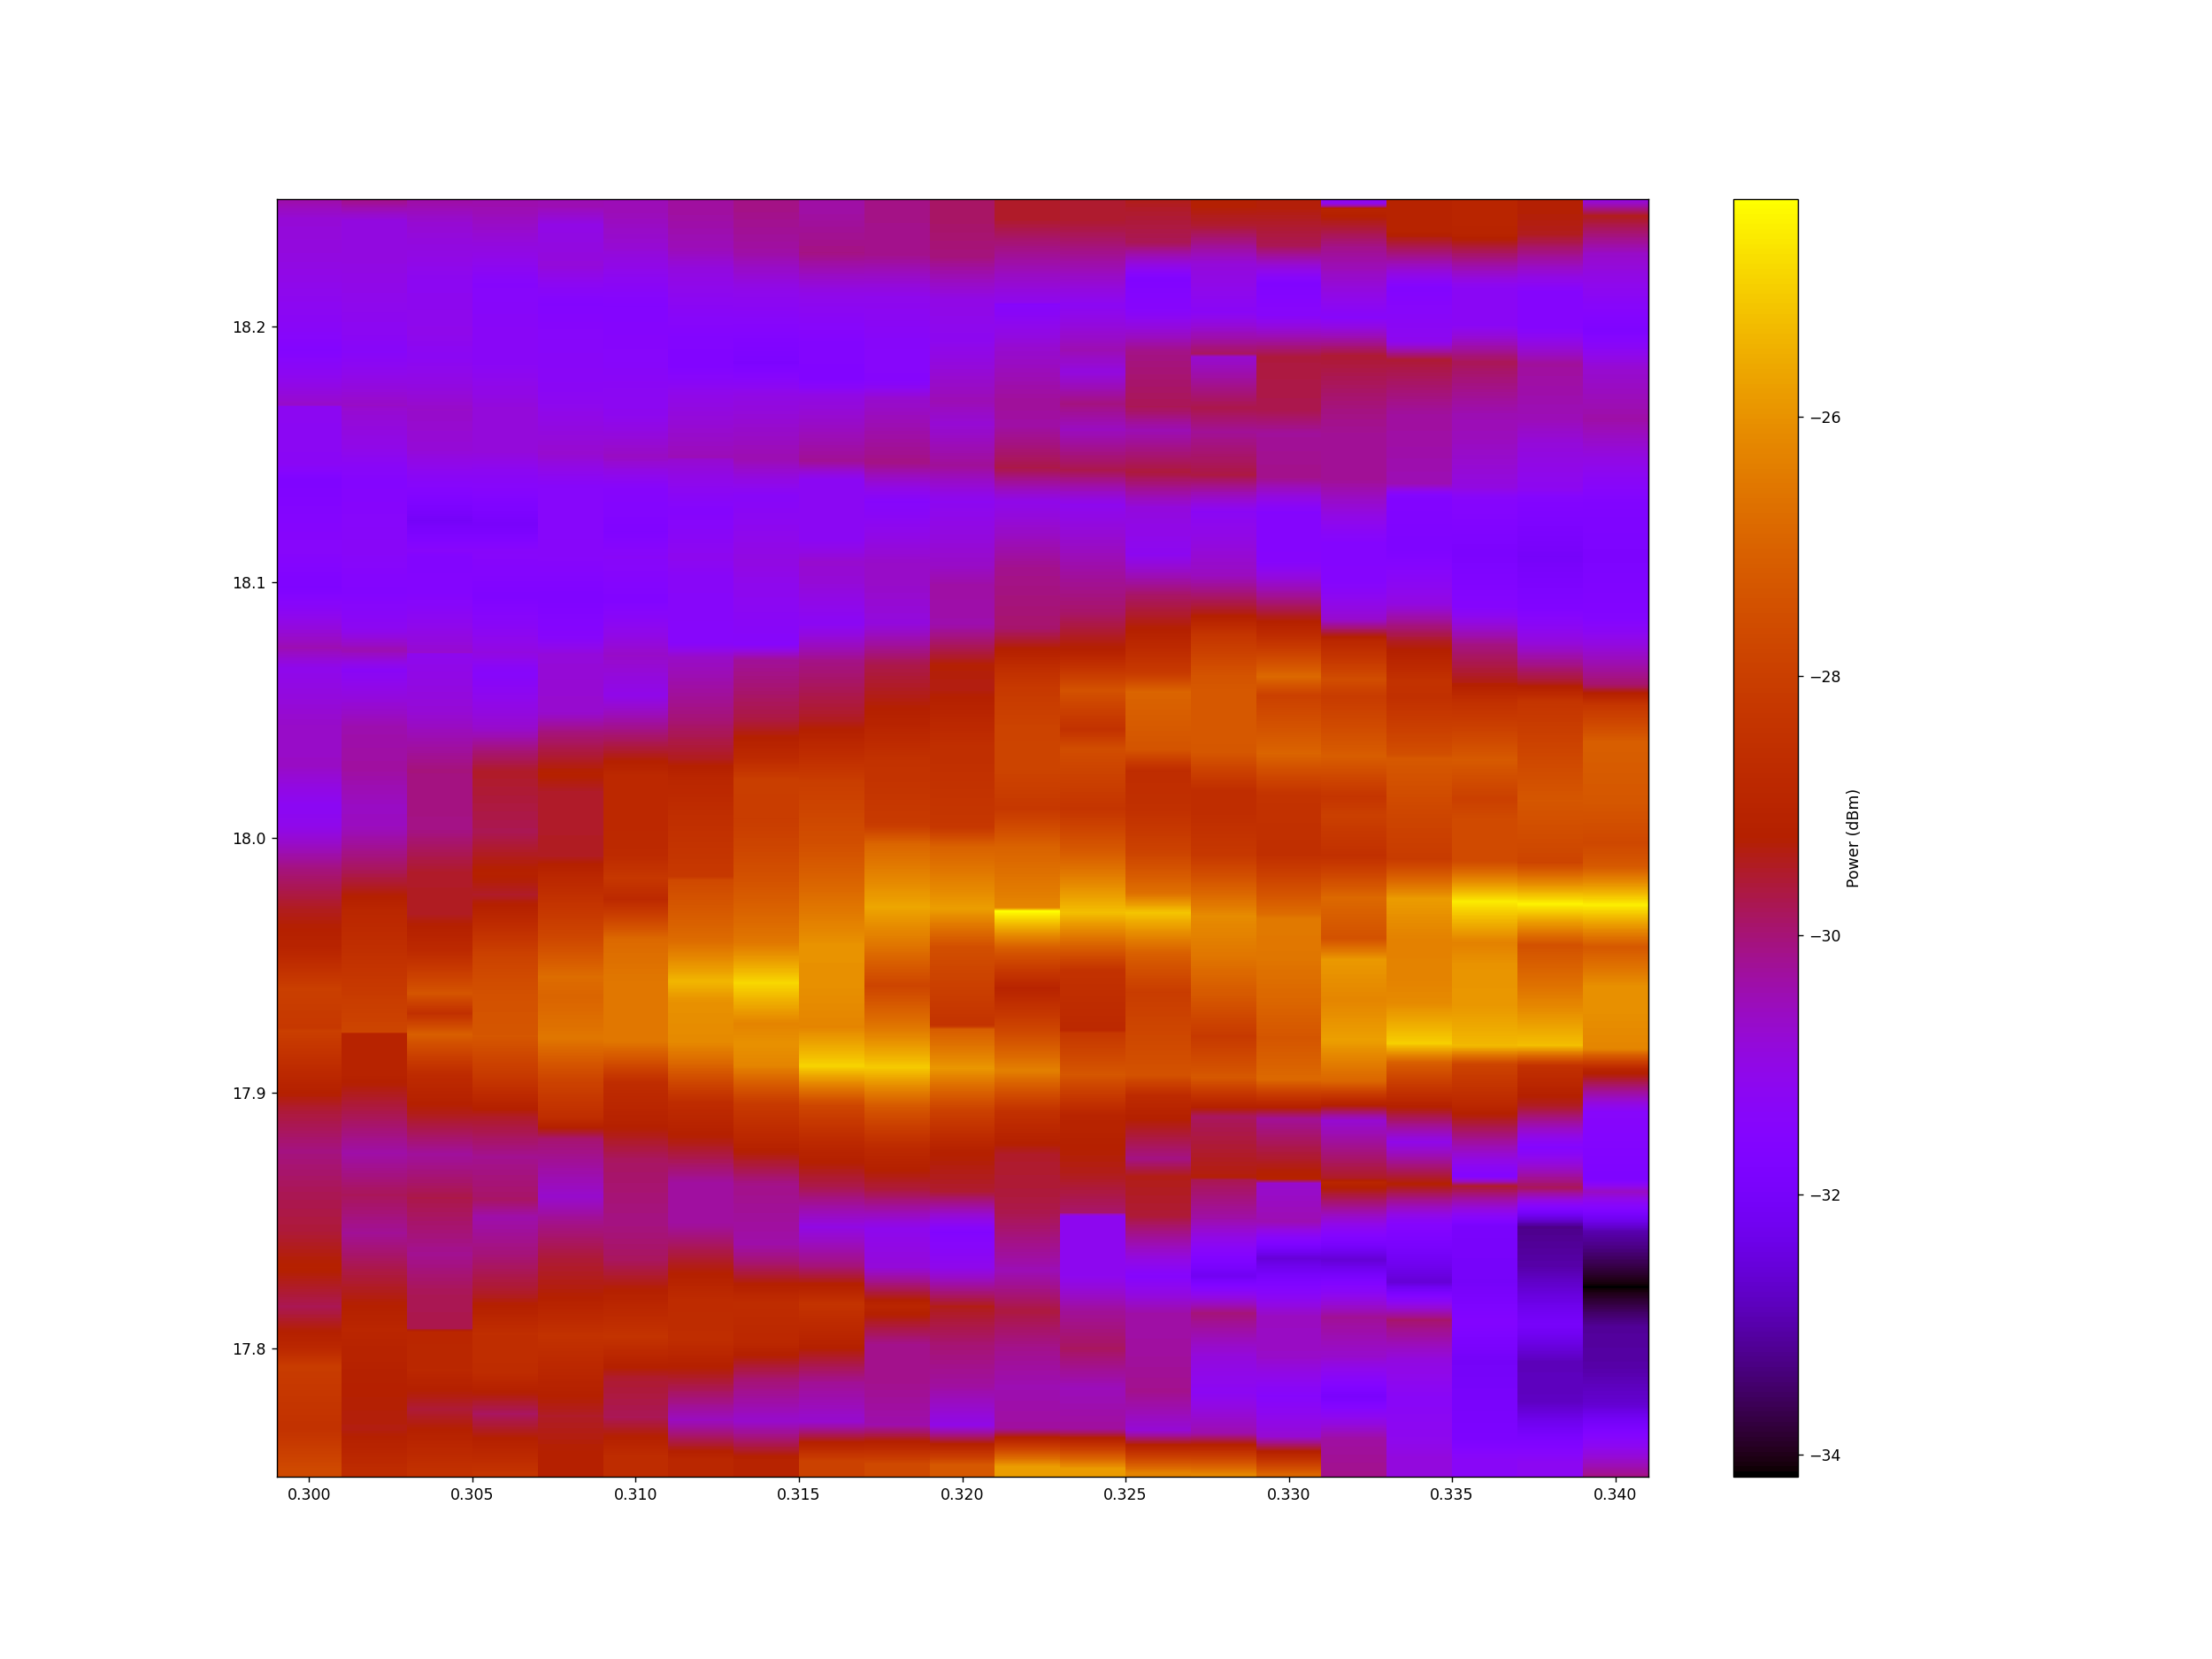

<IPython.core.display.Javascript object>


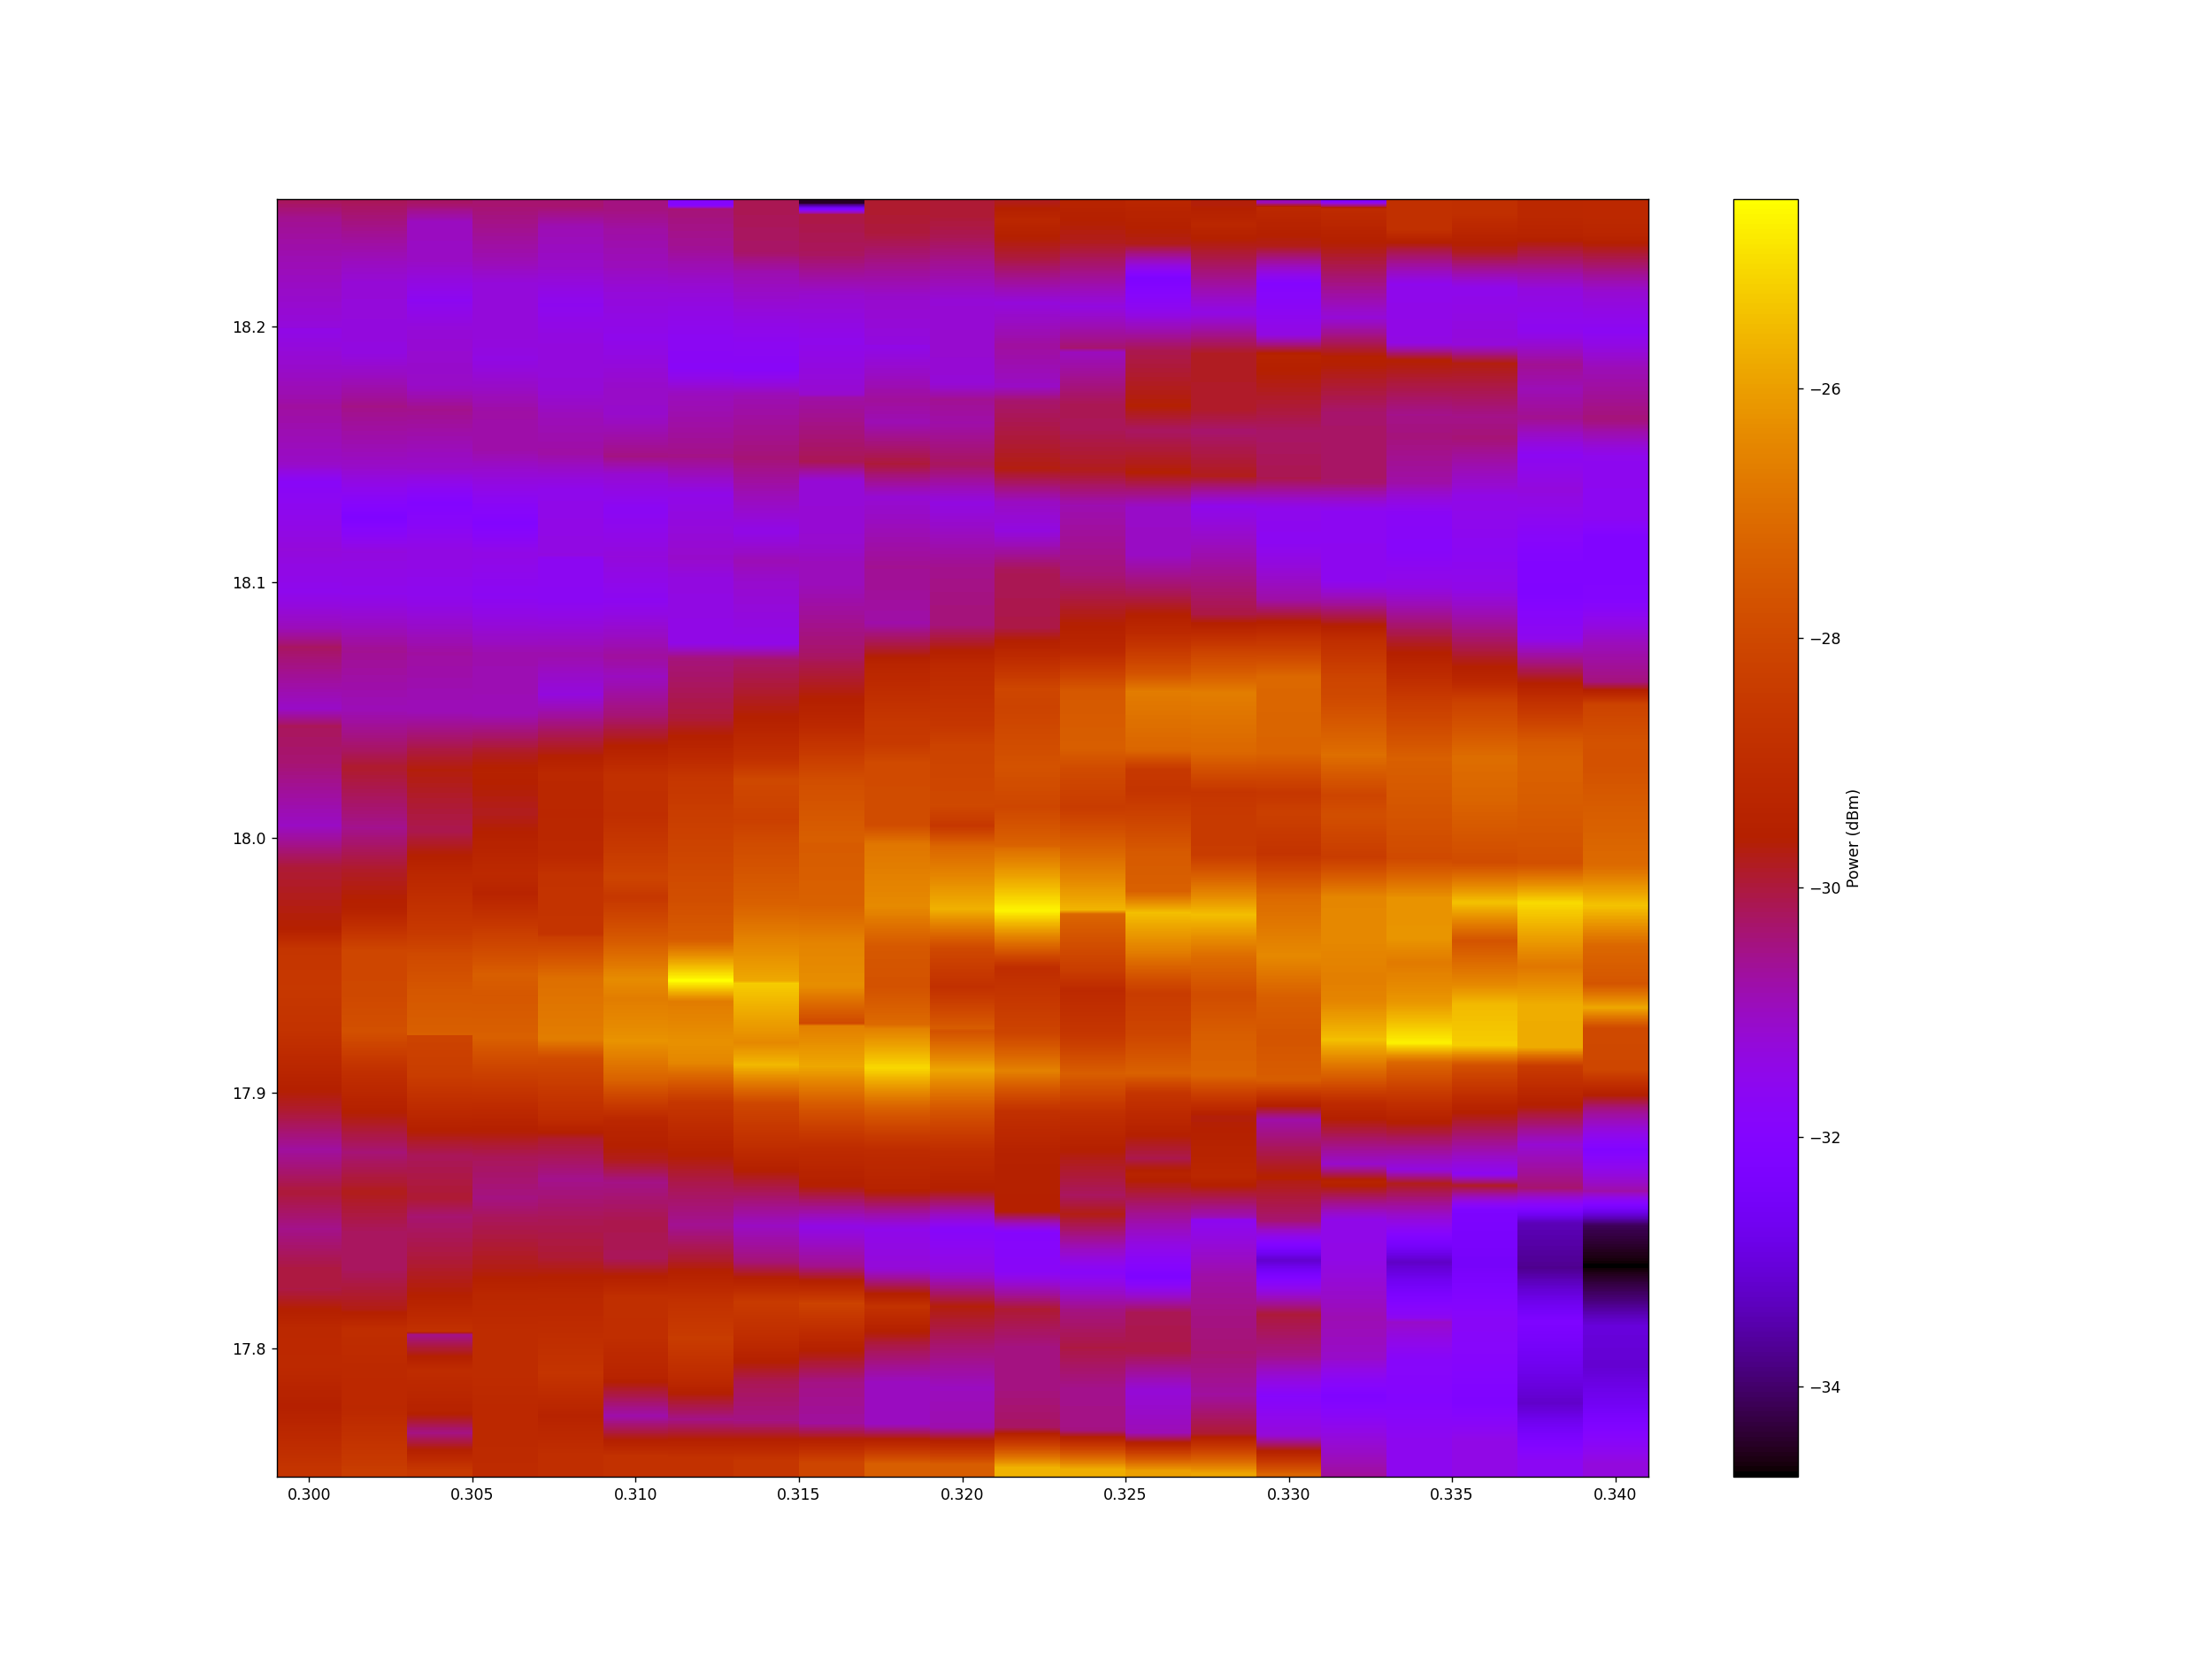

<IPython.core.display.Javascript object>


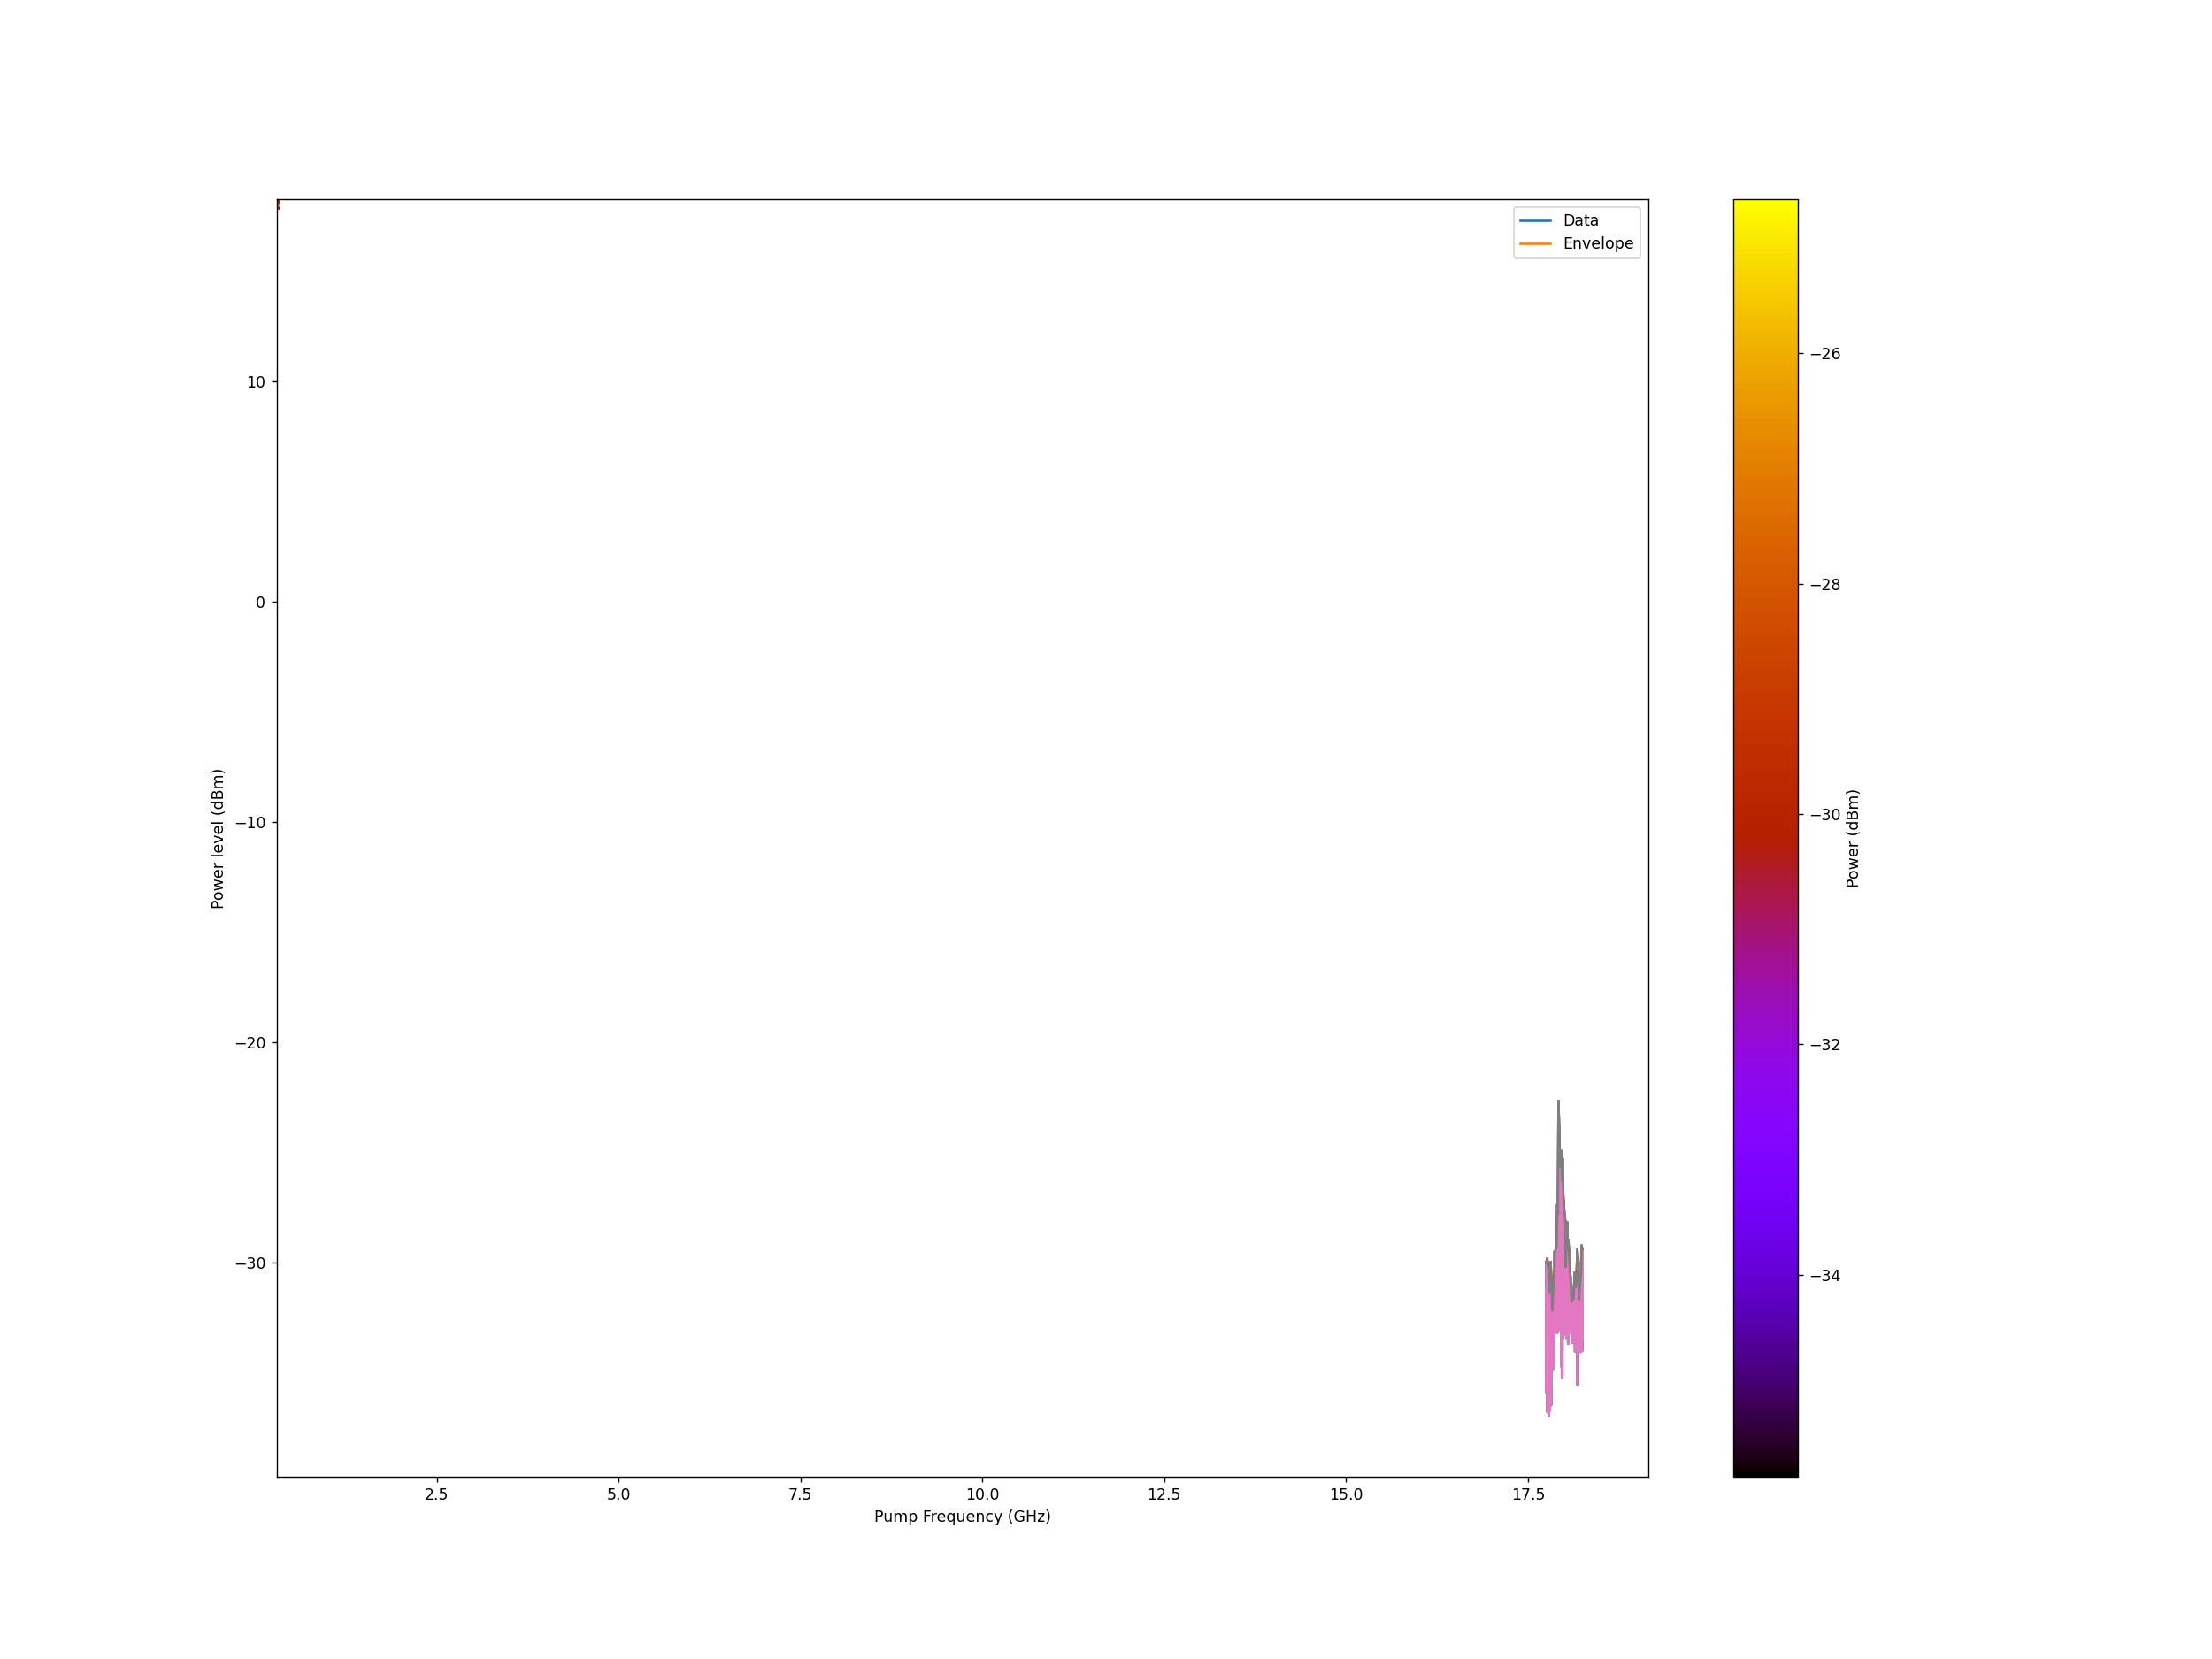

Saved images


In [28]:
for i in range(0,N_p):
    fig = plt.figure(figsize=(20,15))

    plot = plt.pcolormesh(V, F, inviluppi[:,:,i], cmap='gnuplot', shading = 'auto')
    fig.colorbar(plot, label = 'Power (dBm)')
    plt.savefig('p' + str(i) + '.png')

print('Saved images')

In [123]:
(0.322-v0)/dv

11.000000000000009

In [120]:
#bias 0.395 V soglia

In [11]:
start_time = time.time()
bias.set_voltage(V[5])
final_time3 = time.time() - start_time
print(final_time3)

0.00500035285949707


In [12]:
start_time = time.time()
pump.set_ampl(P[3])
final_time2 = time.time() - start_time
print(final_time2)

0.002000093460083008


In [13]:
start_time = time.time()
pump.set_freq(F[5])
f, d = field_fox.SA_print_data()
maxima[1][2][5] = max(d)
final_time1 = time.time() - start_time
print(final_time1)

0.6850390434265137


In [16]:
tot_time = (((((final_time1*N_f)+final_time2)*N_p)+final_time3)*N_v)/(3600*24)
print(tot_time)

4.162569708633754
